#### !pip install git+https://github.com/KindXiaoming/pykan.git

In [2]:
!pip install torch matplotlib

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [6]:
pip install scikit-learn==1.3.2

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.1.1 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import matplotlib.pyplot as plt
from kan import *

/home/kunuru/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
!pip install mne
import mne

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [5]:
!pip install moabb

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [7]:
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
from mne import Epochs, pick_types, events_from_annotations
from kan import *
from kan import KAN
from kan import LBFGS
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
import time
import json

# # Set parameters
# epochs = 40        # Increased number of epochs
# batch = 32            # Increased batch size
# lr = 0.01             # Reduced learning rate for stability
# loss_fn = CrossEntropyLoss()
# steps = 20
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# le = LabelEncoder()
# hidden_layers = 8     # Adjusted hidden layer count based on performance

# Set parameters
epochs = 20        # Increased number of epochs
batch = 16           # Increased batch size
lr = 0.1             # Reduced learning rate for stability
loss_fn = CrossEntropyLoss()
steps = 50
kf = KFold(n_splits=10, shuffle=True, random_state=42)
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
le = LabelEncoder()
hidden_layers = 15     # Adjusted hidden layer count based on performance

# Regularization parameters
lamb = 0.005
lamb_l1 = 0.1
lamb_entropy = 0.5

moabb.set_log_level("info")
warnings.filterwarnings("ignore")
csp = CSP(n_components=4, reg='oas')

# Device configuration
device = torch.device('cpu')  # Adjust for GPU if available: 'cuda' if torch.cuda.is_available() else 'cpu'

def data_EEG(subjects, train=True, multiclass=False):
        # Function to load EEG data based on parameters
        if train:
            session_name = "0train"
        else:
            session_name = "1test"

        dataset = BNCI2014_001()

        if multiclass:
            event_id = dict(left=1, right=2, feet=3, tongue=4)
        else:
            event_id = dict(left=1, right=2)

        tmin, tmax = -1., 6.
        runs = range(5)

        epochs_data = []
        for subject in subjects:
            sessions = dataset.get_data(subjects=[subject])
            for run in runs:
                raw = sessions[subject][session_name][str(run)]
                events = mne.find_events(raw, stim_channel="stim")
                picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
                raw.filter(8., 30., method='iir', picks=picks)

                epochs = Epochs(raw,
                                events,
                                event_id,
                                tmin,
                                tmax,
                                proj=True,
                                picks=picks,
                                baseline=None,
                                preload=True,
                                verbose=False)
                epochs_data.append(epochs)
        return epochs_data

def export_json(data, filename):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            data[key] = value.tolist()
        elif isinstance(value, list) and all(isinstance(x, list) for x in value):
            data[key] = [[float(item) for item in sublist] for sublist in value]
        elif isinstance(value, list):
            data[key] = [float(item) for item in value]

    with open(filename, "w") as outfile:
        json.dump(data, outfile, indent=4)

# KANModel class with dynamic grid optimization
class KANModel(Module):
    def __init__(self, input_shape, output_shape, grid=5, k=3, device='cpu'):  # Increased grid size to 5
        super(KANModel, self).__init__()
        self.layer = Linear(input_shape, output_shape)
        self.grid = grid
        self.k = k
        self.device = device

        # Ensure all parameters are in double precision
        for param in self.layer.parameters():
            param.data = param.data.double()

    def forward(self, x):
        return self.layer(x)

    def update_grid_size(self, new_grid_size):
        self.grid = new_grid_size
        
    def initialize_from_another_model(self, other_model, train_input):
        with torch.no_grad():
            if hasattr(other_model, 'layer') and hasattr(self, 'layer'):
                if self.layer.weight.shape == other_model.layer.weight.shape:
                    self.layer.weight.copy_(other_model.layer.weight)
                if self.layer.bias.shape == other_model.layer.bias.shape:
                    self.layer.bias.copy_(other_model.layer.bias)
        return self



    def train_model(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0.01, lamb_l1=0.5, lamb_entropy=1.5,
                    update_grid=True, grid_update_num=10, stop_grid_update_step=50, batch=-1, loss_fn=None,
                    lr=1, plateau_threshold=1e-4, max_grid_size=50, small_mag_threshold=1e-16,
                    small_reg_factor=1., sglr_avoid=False):

        pbar = tqdm(range(steps), desc='Training KAN', ncols=100)

        current_grid_size = self.grid
        best_acc = 0.0
        best_grid_size = current_grid_size

        if loss_fn is None:
            loss_fn = lambda x, y: torch.mean((x - y) ** 2)
        acc = lambda x, y: torch.mean((torch.argmax(x, dim=1) == y).float())

        optimizer = optim.Adam(self.parameters(), lr=lr) if opt == "Adam" else LBFGS(
            self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe")

        results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
        batch_size = dataset['train_input'].shape[0] if batch == -1 or batch > dataset['train_input'].shape[0] else batch

        global train_loss, train_acc

        for step in pbar:
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size, replace=True)

            def closure():
                global train_loss, train_acc
                optimizer.zero_grad()
                pred = self.forward(dataset['train_input'][train_id].to(self.device))
                if sglr_avoid:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(self.device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.device))
                train_acc = acc(pred, dataset['train_label'][train_id].to(self.device))

                objective = train_loss + lamb
                objective.backward()
                return objective

            if opt == "LBFGS":
                optimizer.step(closure)
            else:
                pred = self.forward(dataset['train_input'][train_id].to(self.device))
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn(self.forward(dataset['test_input'][test_id].to(self.device)), dataset['test_label'][test_id].to(self.device))
            test_acc = acc(self.forward(dataset['test_input'][test_id].to(self.device)), dataset['test_label'][test_id].to(self.device))

            if step % log == 0:
                pbar.set_description(f"train acc: {train_acc:.3f} | test acc: {test_acc:.3f}")

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if test_acc > best_acc:
                best_acc = test_acc
                best_grid_size = current_grid_size

            if update_grid and step % grid_update_num == 0 and step < stop_grid_update_step:
                if len(results['train_acc']) > 2:
                    acc_diff = abs(results['train_acc'][-1] - results['train_acc'][-2])
                    if acc_diff < plateau_threshold and current_grid_size < max_grid_size:
                        current_grid_size += 1
                        self.update_grid_size(current_grid_size)
                        pbar.set_postfix({'grid_size': current_grid_size})

        self.update_grid_size(best_grid_size)
        print(f"Reverting to best grid size: {best_grid_size} with accuracy: {best_acc:.3f}")

        return results


class MLP(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),  # Activation function (you can experiment with others)
            Linear(hidden_dim, output_dim)  # Output layer
        )

    def forward(self, x):
        return self.layers(x)
    
    def initialize_from_another_model(self, model, data):
        """ Initialize the current model from another model using the data provided """
        # Assuming we are initializing the weights from another model
        self.kan.initialize_from(model.kan)
        return self
    

    def train(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        '''


        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        acc = acc_eval = lambda x,y: torch.mean((torch.argmax(x, dim=1) == y).float())

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['train_acc'] = []
        results['test_acc'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, train_acc

        def closure():
            global train_loss, train_acc
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            train_acc = acc(pred, dataset['train_label'][train_id].to(device))

            objective = train_loss + lamb
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:

            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            #if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
            #    self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))
            test_acc = acc_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

            if _ % log == 0:
                pbar.set_description("train acc: %.3f | test acc: %.3f " % ((train_acc).cpu().detach().numpy(), (test_acc).cpu().detach().numpy()))

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()

        return results

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [9]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 0.556: 100%|██████████████| 20/20 [00:00<00:00, 64.92it/s, grid_size=6]


Reverting to best grid size: 6 with accuracy: 0.685


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 22.92it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 0.620: 100%|█████████████| 20/20 [00:00<00:00, 295.78it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.657


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 32.05it/s]


###### EPOCH 2 ######


train acc: 0.769 | test acc: 0.602: 100%|█████████████| 20/20 [00:00<00:00, 307.97it/s, grid_size=7]


Reverting to best grid size: 7 with accuracy: 0.694


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 57.02it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.639: 100%|█████████████| 20/20 [00:00<00:00, 306.27it/s, grid_size=8]


Reverting to best grid size: 8 with accuracy: 0.704


train acc: 0.759 | test acc: 0.417 : 100%|█████████████████████████| 20/20 [00:00<00:00, 123.65it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.565: 100%|█████████████| 20/20 [00:00<00:00, 305.49it/s, grid_size=9]


Reverting to best grid size: 8 with accuracy: 0.667


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.13it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.556: 100%|█████████████| 20/20 [00:00<00:00, 307.48it/s, grid_size=9]


Reverting to best grid size: 8 with accuracy: 0.648


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.20it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.611: 100%|█████████████| 20/20 [00:00<00:00, 305.51it/s, grid_size=9]


Reverting to best grid size: 9 with accuracy: 0.676


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.12it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.583: 100%|████████████| 20/20 [00:00<00:00, 307.00it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.685


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.15it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.574: 100%|████████████| 20/20 [00:00<00:00, 305.23it/s, grid_size=11]


Reverting to best grid size: 11 with accuracy: 0.648


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 53.98it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.574: 100%|████████████| 20/20 [00:00<00:00, 303.02it/s, grid_size=12]


Reverting to best grid size: 12 with accuracy: 0.685


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 53.88it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.611: 100%|████████████| 20/20 [00:00<00:00, 305.53it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.657


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 53.88it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.639: 100%|████████████| 20/20 [00:00<00:00, 306.77it/s, grid_size=13]


Reverting to best grid size: 13 with accuracy: 0.639


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.07it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.602: 100%|████████████| 20/20 [00:00<00:00, 307.84it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.657


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 53.98it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.556: 100%|████████████| 20/20 [00:00<00:00, 311.66it/s, grid_size=14]


Reverting to best grid size: 14 with accuracy: 0.639


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.03it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.593: 100%|████████████| 20/20 [00:00<00:00, 309.13it/s, grid_size=15]


Reverting to best grid size: 15 with accuracy: 0.667


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.06it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.583: 100%|████████████| 20/20 [00:00<00:00, 308.45it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.630


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.03it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.667: 100%|████████████| 20/20 [00:00<00:00, 310.19it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.685


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.13it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.611: 100%|████████████| 20/20 [00:00<00:00, 315.25it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.685


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.40it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.519: 100%|████████████| 20/20 [00:00<00:00, 330.05it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.676


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.75it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.611: 100%|████████████| 20/20 [00:00<00:00, 282.99it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.657


train acc: 0.759 | test acc: 0.417 : 100%|██████████████████████████| 20/20 [00:00<00:00, 48.73it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.843 | test acc: 0.296: 100%|████████████| 20/20 [00:00<00:00, 107.84it/s, grid_size=17]


Reverting to best grid size: 17 with accuracy: 0.472


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.86it/s]


###### EPOCH 1 ######


train acc: 0.843 | test acc: 0.343: 100%|████████████| 20/20 [00:00<00:00, 308.50it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.352


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.40it/s]


###### EPOCH 2 ######


train acc: 0.843 | test acc: 0.398: 100%|████████████| 20/20 [00:00<00:00, 309.96it/s, grid_size=18]


Reverting to best grid size: 18 with accuracy: 0.435


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 66.70it/s]


###### EPOCH 3 ######


train acc: 0.843 | test acc: 0.296: 100%|████████████| 20/20 [00:00<00:00, 308.04it/s, grid_size=19]


Reverting to best grid size: 18 with accuracy: 0.426


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.81it/s]


###### EPOCH 4 ######


train acc: 0.843 | test acc: 0.352: 100%|████████████| 20/20 [00:00<00:00, 307.23it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.426


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.92it/s]


###### EPOCH 5 ######


train acc: 0.843 | test acc: 0.398: 100%|████████████| 20/20 [00:00<00:00, 321.33it/s, grid_size=20]


Reverting to best grid size: 19 with accuracy: 0.454


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.20it/s]


###### EPOCH 6 ######


train acc: 0.843 | test acc: 0.296: 100%|████████████| 20/20 [00:00<00:00, 325.11it/s, grid_size=20]


Reverting to best grid size: 19 with accuracy: 0.398


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.93it/s]


###### EPOCH 7 ######


train acc: 0.843 | test acc: 0.315: 100%|████████████| 20/20 [00:00<00:00, 305.42it/s, grid_size=20]


Reverting to best grid size: 19 with accuracy: 0.389


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.72it/s]


###### EPOCH 8 ######


train acc: 0.843 | test acc: 0.315: 100%|████████████| 20/20 [00:00<00:00, 308.50it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.407


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.84it/s]


###### EPOCH 9 ######


train acc: 0.843 | test acc: 0.343: 100%|████████████| 20/20 [00:00<00:00, 308.46it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.370


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.81it/s]


###### EPOCH 10 ######


train acc: 0.843 | test acc: 0.333: 100%|████████████| 20/20 [00:00<00:00, 304.69it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.463


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 52.65it/s]


###### EPOCH 11 ######


train acc: 0.843 | test acc: 0.343: 100%|████████████| 20/20 [00:00<00:00, 292.28it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.417


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.97it/s]


###### EPOCH 12 ######


train acc: 0.843 | test acc: 0.296: 100%|████████████| 20/20 [00:00<00:00, 276.66it/s, grid_size=21]


Reverting to best grid size: 21 with accuracy: 0.407


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 66.49it/s]


###### EPOCH 13 ######


train acc: 0.843 | test acc: 0.343: 100%|████████████| 20/20 [00:00<00:00, 286.28it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.435


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 63.29it/s]


###### EPOCH 14 ######


train acc: 0.843 | test acc: 0.296: 100%|████████████| 20/20 [00:00<00:00, 238.58it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.444


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 67.65it/s]


###### EPOCH 15 ######


train acc: 0.843 | test acc: 0.315: 100%|████████████| 20/20 [00:00<00:00, 256.26it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.426


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 57.62it/s]


###### EPOCH 16 ######


train acc: 0.843 | test acc: 0.417: 100%|████████████| 20/20 [00:00<00:00, 324.65it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.417


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.91it/s]


###### EPOCH 17 ######


train acc: 0.843 | test acc: 0.370: 100%|████████████| 20/20 [00:00<00:00, 284.57it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.454


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 63.02it/s]


###### EPOCH 18 ######


train acc: 0.843 | test acc: 0.389: 100%|████████████| 20/20 [00:00<00:00, 255.44it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.398


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 62.93it/s]


###### EPOCH 19 ######


train acc: 0.843 | test acc: 0.380: 100%|████████████| 20/20 [00:00<00:00, 282.48it/s, grid_size=23]


Reverting to best grid size: 23 with accuracy: 0.380


train acc: 0.861 | test acc: 0.333 : 100%|██████████████████████████| 20/20 [00:00<00:00, 63.35it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.843: 100%|█████████████| 20/20 [00:00<00:00, 92.64it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.880


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 36.91it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.750: 100%|████████████| 20/20 [00:00<00:00, 326.34it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.36it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.824: 100%|████████████| 20/20 [00:00<00:00, 326.16it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.59it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.759: 100%|████████████| 20/20 [00:00<00:00, 323.26it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.907


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.49it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.824: 100%|████████████| 20/20 [00:00<00:00, 327.31it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.861


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.59it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.833: 100%|████████████| 20/20 [00:00<00:00, 324.22it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.62it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.870: 100%|████████████| 20/20 [00:00<00:00, 326.11it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.38it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.870: 100%|████████████| 20/20 [00:00<00:00, 322.75it/s, grid_size=25]


Reverting to best grid size: 25 with accuracy: 0.917


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.41it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.796: 100%|████████████| 20/20 [00:00<00:00, 326.19it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.852


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.33it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.833: 100%|████████████| 20/20 [00:00<00:00, 326.23it/s, grid_size=26]


Reverting to best grid size: 26 with accuracy: 0.880


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.26it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.833: 100%|████████████| 20/20 [00:00<00:00, 324.42it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.42it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 323.30it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.880


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.54it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.870: 100%|████████████| 20/20 [00:00<00:00, 325.17it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.898


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.49it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 327.58it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.935


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.50it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.824: 100%|████████████| 20/20 [00:00<00:00, 324.51it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.917


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.48it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.704: 100%|████████████| 20/20 [00:00<00:00, 317.51it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.880


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.46it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.806: 100%|████████████| 20/20 [00:00<00:00, 317.38it/s, grid_size=27]


Reverting to best grid size: 27 with accuracy: 0.907


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.32it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.787: 100%|████████████| 20/20 [00:00<00:00, 325.15it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.917


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.12it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.824: 100%|████████████| 20/20 [00:00<00:00, 322.62it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.889


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.15it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.833: 100%|████████████| 20/20 [00:00<00:00, 325.93it/s, grid_size=29]


Reverting to best grid size: 28 with accuracy: 0.889


train acc: 0.778 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.44it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.778 | test acc: 0.806: 100%|████████████| 20/20 [00:00<00:00, 133.34it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.898


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 39.09it/s]


###### EPOCH 1 ######


train acc: 0.778 | test acc: 0.917: 100%|████████████| 20/20 [00:00<00:00, 323.11it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.57it/s]


###### EPOCH 2 ######


train acc: 0.778 | test acc: 0.861: 100%|████████████| 20/20 [00:00<00:00, 323.98it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.898


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 35.98it/s]


###### EPOCH 3 ######


train acc: 0.778 | test acc: 0.824: 100%|████████████| 20/20 [00:00<00:00, 326.72it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.926


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 33.02it/s]


###### EPOCH 4 ######


train acc: 0.778 | test acc: 0.870: 100%|████████████| 20/20 [00:00<00:00, 328.66it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.898


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.19it/s]


###### EPOCH 5 ######


train acc: 0.778 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 329.47it/s, grid_size=32]


Reverting to best grid size: 32 with accuracy: 0.907


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.10it/s]


###### EPOCH 6 ######


train acc: 0.778 | test acc: 0.806: 100%|████████████| 20/20 [00:00<00:00, 325.19it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.880


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.27it/s]


###### EPOCH 7 ######


train acc: 0.778 | test acc: 0.815: 100%|████████████| 20/20 [00:00<00:00, 325.59it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.870


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.23it/s]


###### EPOCH 8 ######


train acc: 0.778 | test acc: 0.815: 100%|████████████| 20/20 [00:00<00:00, 325.67it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.880


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.15it/s]


###### EPOCH 9 ######


train acc: 0.778 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 327.43it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.917


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.25it/s]


###### EPOCH 10 ######


train acc: 0.778 | test acc: 0.806: 100%|████████████| 20/20 [00:00<00:00, 323.43it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.880


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 63.29it/s]


###### EPOCH 11 ######


train acc: 0.778 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 308.26it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.889


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.42it/s]


###### EPOCH 12 ######


train acc: 0.778 | test acc: 0.769: 100%|████████████| 20/20 [00:00<00:00, 310.02it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.917


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.47it/s]


###### EPOCH 13 ######


train acc: 0.778 | test acc: 0.806: 100%|████████████| 20/20 [00:00<00:00, 311.06it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.926


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.61it/s]


###### EPOCH 14 ######


train acc: 0.778 | test acc: 0.815: 100%|████████████| 20/20 [00:00<00:00, 312.85it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.907


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.60it/s]


###### EPOCH 15 ######


train acc: 0.778 | test acc: 0.907: 100%|████████████| 20/20 [00:00<00:00, 305.50it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.907


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.66it/s]


###### EPOCH 16 ######


train acc: 0.778 | test acc: 0.787: 100%|████████████| 20/20 [00:00<00:00, 332.44it/s, grid_size=35]


Reverting to best grid size: 35 with accuracy: 0.889


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.25it/s]


###### EPOCH 17 ######


train acc: 0.778 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 337.91it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.870


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.99it/s]


###### EPOCH 18 ######


train acc: 0.778 | test acc: 0.852: 100%|████████████| 20/20 [00:00<00:00, 333.43it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.907


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.96it/s]


###### EPOCH 19 ######


train acc: 0.778 | test acc: 0.861: 100%|████████████| 20/20 [00:00<00:00, 336.93it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.861


train acc: 0.824 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.30it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.731 | test acc: 0.667: 100%|████████████| 20/20 [00:00<00:00, 128.78it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.741


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.52it/s]


###### EPOCH 1 ######


train acc: 0.731 | test acc: 0.685: 100%|████████████| 20/20 [00:00<00:00, 338.45it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.731


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.30it/s]


###### EPOCH 2 ######


train acc: 0.731 | test acc: 0.620: 100%|████████████| 20/20 [00:00<00:00, 330.83it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.759


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.29it/s]


###### EPOCH 3 ######


train acc: 0.731 | test acc: 0.676: 100%|████████████| 20/20 [00:00<00:00, 337.57it/s, grid_size=36]


Reverting to best grid size: 36 with accuracy: 0.741


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.90it/s]


###### EPOCH 4 ######


train acc: 0.731 | test acc: 0.648: 100%|████████████| 20/20 [00:00<00:00, 324.39it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.750


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.53it/s]


###### EPOCH 5 ######


train acc: 0.731 | test acc: 0.676: 100%|████████████| 20/20 [00:00<00:00, 319.40it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.694


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.44it/s]


###### EPOCH 6 ######


train acc: 0.731 | test acc: 0.685: 100%|████████████| 20/20 [00:00<00:00, 327.79it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.731


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.38it/s]


###### EPOCH 7 ######


train acc: 0.731 | test acc: 0.648: 100%|████████████| 20/20 [00:00<00:00, 325.78it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.759


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.58it/s]


###### EPOCH 8 ######


train acc: 0.731 | test acc: 0.731: 100%|████████████| 20/20 [00:00<00:00, 323.67it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.731


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.50it/s]


###### EPOCH 9 ######


train acc: 0.731 | test acc: 0.769: 100%|████████████| 20/20 [00:00<00:00, 324.95it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.769


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.07it/s]


###### EPOCH 10 ######


train acc: 0.731 | test acc: 0.630: 100%|████████████| 20/20 [00:00<00:00, 324.73it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.750


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.74it/s]


###### EPOCH 11 ######


train acc: 0.731 | test acc: 0.713: 100%|████████████| 20/20 [00:00<00:00, 322.81it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.778


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.39it/s]


###### EPOCH 12 ######


train acc: 0.731 | test acc: 0.769: 100%|████████████| 20/20 [00:00<00:00, 326.01it/s, grid_size=40]


Reverting to best grid size: 40 with accuracy: 0.769


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.45it/s]


###### EPOCH 13 ######


train acc: 0.731 | test acc: 0.704: 100%|████████████| 20/20 [00:00<00:00, 329.77it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.741


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.72it/s]


###### EPOCH 14 ######


train acc: 0.731 | test acc: 0.648: 100%|████████████| 20/20 [00:00<00:00, 325.98it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.769


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.47it/s]


###### EPOCH 15 ######


train acc: 0.731 | test acc: 0.694: 100%|████████████| 20/20 [00:00<00:00, 326.70it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.750


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.13it/s]


###### EPOCH 16 ######


train acc: 0.731 | test acc: 0.713: 100%|████████████| 20/20 [00:00<00:00, 323.65it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.750


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.35it/s]


###### EPOCH 17 ######


train acc: 0.731 | test acc: 0.602: 100%|████████████| 20/20 [00:00<00:00, 323.69it/s, grid_size=42]


Reverting to best grid size: 41 with accuracy: 0.750


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.14it/s]


###### EPOCH 18 ######


train acc: 0.731 | test acc: 0.722: 100%|████████████| 20/20 [00:00<00:00, 324.05it/s, grid_size=42]


Reverting to best grid size: 41 with accuracy: 0.759


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.47it/s]


###### EPOCH 19 ######


train acc: 0.731 | test acc: 0.676: 100%|████████████| 20/20 [00:00<00:00, 324.53it/s, grid_size=42]


Reverting to best grid size: 42 with accuracy: 0.769


train acc: 0.824 | test acc: 0.833 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.55it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.750 | test acc: 0.593: 100%|████████████| 20/20 [00:00<00:00, 139.11it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.630


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 39.35it/s]


###### EPOCH 1 ######


train acc: 0.750 | test acc: 0.639: 100%|████████████| 20/20 [00:00<00:00, 332.13it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.685


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 78.60it/s]


###### EPOCH 2 ######


train acc: 0.750 | test acc: 0.639: 100%|████████████| 20/20 [00:00<00:00, 326.70it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.722


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.41it/s]


###### EPOCH 3 ######


train acc: 0.750 | test acc: 0.648: 100%|████████████| 20/20 [00:00<00:00, 321.55it/s, grid_size=46]


Reverting to best grid size: 45 with accuracy: 0.648


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.64it/s]


###### EPOCH 4 ######


train acc: 0.750 | test acc: 0.639: 100%|████████████| 20/20 [00:00<00:00, 326.22it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.657


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.31it/s]


###### EPOCH 5 ######


train acc: 0.750 | test acc: 0.593: 100%|████████████| 20/20 [00:00<00:00, 324.37it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.648


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.94it/s]


###### EPOCH 6 ######


train acc: 0.750 | test acc: 0.583: 100%|████████████| 20/20 [00:00<00:00, 326.30it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.676


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.59it/s]


###### EPOCH 7 ######


train acc: 0.750 | test acc: 0.472: 100%|████████████| 20/20 [00:00<00:00, 327.25it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.676


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.06it/s]


###### EPOCH 8 ######


train acc: 0.750 | test acc: 0.602: 100%|████████████| 20/20 [00:00<00:00, 322.00it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.676


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.95it/s]


###### EPOCH 9 ######


train acc: 0.750 | test acc: 0.546: 100%|████████████| 20/20 [00:00<00:00, 327.43it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.722


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.64it/s]


###### EPOCH 10 ######


train acc: 0.750 | test acc: 0.713: 100%|████████████| 20/20 [00:00<00:00, 327.64it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.713


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.99it/s]


###### EPOCH 11 ######


train acc: 0.750 | test acc: 0.593: 100%|████████████| 20/20 [00:00<00:00, 323.67it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.667


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.69it/s]


###### EPOCH 12 ######


train acc: 0.750 | test acc: 0.528: 100%|████████████| 20/20 [00:00<00:00, 324.55it/s, grid_size=49]


Reverting to best grid size: 48 with accuracy: 0.639


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.95it/s]


###### EPOCH 13 ######


train acc: 0.750 | test acc: 0.537: 100%|████████████| 20/20 [00:00<00:00, 323.04it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.648


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.47it/s]


###### EPOCH 14 ######


train acc: 0.750 | test acc: 0.620: 100%|████████████| 20/20 [00:00<00:00, 327.98it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.676


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.24it/s]


###### EPOCH 15 ######


train acc: 0.750 | test acc: 0.648: 100%|████████████| 20/20 [00:00<00:00, 325.16it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.82it/s]


###### EPOCH 16 ######


train acc: 0.750 | test acc: 0.509: 100%|██████████████████████████| 20/20 [00:00<00:00, 327.03it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.17it/s]


###### EPOCH 17 ######


train acc: 0.750 | test acc: 0.583: 100%|██████████████████████████| 20/20 [00:00<00:00, 330.93it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.27it/s]


###### EPOCH 18 ######


train acc: 0.750 | test acc: 0.593: 100%|██████████████████████████| 20/20 [00:00<00:00, 286.70it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 70.44it/s]


###### EPOCH 19 ######


train acc: 0.750 | test acc: 0.565: 100%|██████████████████████████| 20/20 [00:00<00:00, 267.61it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 59.12it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 20/20 [00:00<00:00, 138.02it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 31.87it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.09it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 36.70it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 20/20 [00:00<00:00, 323.22it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|█████████████████████████| 20/20 [00:00<00:00, 147.51it/s]


###### EPOCH 3 ######


train acc: 0.759 | test acc: 0.852: 100%|██████████████████████████| 20/20 [00:00<00:00, 325.07it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.97it/s]


###### EPOCH 4 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 20/20 [00:00<00:00, 330.37it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.95it/s]


###### EPOCH 5 ######


train acc: 0.759 | test acc: 0.861: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.81it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.05it/s]


###### EPOCH 6 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 20/20 [00:00<00:00, 329.33it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.15it/s]


###### EPOCH 7 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.05it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.80it/s]


###### EPOCH 8 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 20/20 [00:00<00:00, 342.30it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.37it/s]


###### EPOCH 9 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.93it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.04it/s]


###### EPOCH 10 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 20/20 [00:00<00:00, 339.88it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.34it/s]


###### EPOCH 11 ######


train acc: 0.759 | test acc: 0.815: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.50it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.20it/s]


###### EPOCH 12 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.32it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.34it/s]


###### EPOCH 13 ######


train acc: 0.759 | test acc: 0.852: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.19it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.24it/s]


###### EPOCH 14 ######


train acc: 0.759 | test acc: 0.815: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.89it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.83it/s]


###### EPOCH 15 ######


train acc: 0.759 | test acc: 0.778: 100%|██████████████████████████| 20/20 [00:00<00:00, 334.98it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.00it/s]


###### EPOCH 16 ######


train acc: 0.759 | test acc: 0.880: 100%|██████████████████████████| 20/20 [00:00<00:00, 334.72it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.68it/s]


###### EPOCH 17 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.86it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.43it/s]


###### EPOCH 18 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.08it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.94it/s]


###### EPOCH 19 ######


train acc: 0.759 | test acc: 0.824: 100%|██████████████████████████| 20/20 [00:00<00:00, 342.49it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.31it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.722 | test acc: 0.944: 100%|███████████████████████████| 20/20 [00:00<00:00, 87.26it/s]


Reverting to best grid size: 50 with accuracy: 0.944


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 44.94it/s]


###### EPOCH 1 ######


train acc: 0.722 | test acc: 0.898: 100%|██████████████████████████| 20/20 [00:00<00:00, 341.03it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.71it/s]


###### EPOCH 2 ######


train acc: 0.722 | test acc: 0.861: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.52it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 73.14it/s]


###### EPOCH 3 ######


train acc: 0.722 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.10it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.64it/s]


###### EPOCH 4 ######


train acc: 0.722 | test acc: 0.926: 100%|██████████████████████████| 20/20 [00:00<00:00, 339.90it/s]


Reverting to best grid size: 50 with accuracy: 0.944


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.98it/s]


###### EPOCH 5 ######


train acc: 0.722 | test acc: 0.880: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.45it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.51it/s]


###### EPOCH 6 ######


train acc: 0.722 | test acc: 0.917: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.14it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.61it/s]


###### EPOCH 7 ######


train acc: 0.722 | test acc: 0.954: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.41it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 73.02it/s]


###### EPOCH 8 ######


train acc: 0.722 | test acc: 0.954: 100%|██████████████████████████| 20/20 [00:00<00:00, 340.38it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.42it/s]


###### EPOCH 9 ######


train acc: 0.722 | test acc: 0.944: 100%|██████████████████████████| 20/20 [00:00<00:00, 339.56it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.99it/s]


###### EPOCH 10 ######


train acc: 0.722 | test acc: 0.935: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.97it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.52it/s]


###### EPOCH 11 ######


train acc: 0.722 | test acc: 0.898: 100%|██████████████████████████| 20/20 [00:00<00:00, 335.32it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.99it/s]


###### EPOCH 12 ######


train acc: 0.722 | test acc: 0.926: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.47it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.63it/s]


###### EPOCH 13 ######


train acc: 0.722 | test acc: 0.926: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.96it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.98it/s]


###### EPOCH 14 ######


train acc: 0.722 | test acc: 0.935: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.45it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.88it/s]


###### EPOCH 15 ######


train acc: 0.722 | test acc: 0.926: 100%|██████████████████████████| 20/20 [00:00<00:00, 340.72it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.52it/s]


###### EPOCH 16 ######


train acc: 0.722 | test acc: 0.907: 100%|██████████████████████████| 20/20 [00:00<00:00, 343.14it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.42it/s]


###### EPOCH 17 ######


train acc: 0.722 | test acc: 0.935: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.13it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.71it/s]


###### EPOCH 18 ######


train acc: 0.722 | test acc: 0.898: 100%|██████████████████████████| 20/20 [00:00<00:00, 334.86it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.81it/s]


###### EPOCH 19 ######


train acc: 0.722 | test acc: 0.907: 100%|██████████████████████████| 20/20 [00:00<00:00, 334.53it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.787 | test acc: 1.000 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.13it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.759 | test acc: 0.806: 100%|██████████████████████████| 20/20 [00:00<00:00, 102.18it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.51it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.880: 100%|██████████████████████████| 20/20 [00:00<00:00, 321.48it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.59it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 20/20 [00:00<00:00, 328.38it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.47it/s]


###### EPOCH 3 ######


train acc: 0.759 | test acc: 0.815: 100%|██████████████████████████| 20/20 [00:00<00:00, 334.23it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.72it/s]


###### EPOCH 4 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 20/20 [00:00<00:00, 330.24it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.50it/s]


###### EPOCH 5 ######


train acc: 0.759 | test acc: 0.880: 100%|██████████████████████████| 20/20 [00:00<00:00, 327.64it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.50it/s]


###### EPOCH 6 ######


train acc: 0.759 | test acc: 0.815: 100%|██████████████████████████| 20/20 [00:00<00:00, 321.65it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.46it/s]


###### EPOCH 7 ######


train acc: 0.759 | test acc: 0.852: 100%|██████████████████████████| 20/20 [00:00<00:00, 329.12it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.11it/s]


###### EPOCH 8 ######


train acc: 0.759 | test acc: 0.880: 100%|██████████████████████████| 20/20 [00:00<00:00, 328.07it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.45it/s]


###### EPOCH 9 ######


train acc: 0.759 | test acc: 0.898: 100%|██████████████████████████| 20/20 [00:00<00:00, 327.00it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.31it/s]


###### EPOCH 10 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 328.88it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.24it/s]


###### EPOCH 11 ######


train acc: 0.759 | test acc: 0.861: 100%|██████████████████████████| 20/20 [00:00<00:00, 330.37it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.73it/s]


###### EPOCH 12 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 327.85it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.40it/s]


###### EPOCH 13 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.57it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.77it/s]


###### EPOCH 14 ######


train acc: 0.759 | test acc: 0.889: 100%|██████████████████████████| 20/20 [00:00<00:00, 328.42it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.41it/s]


###### EPOCH 15 ######


train acc: 0.759 | test acc: 0.824: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.77it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.44it/s]


###### EPOCH 16 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.44it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.72it/s]


###### EPOCH 17 ######


train acc: 0.759 | test acc: 0.750: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.99it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.21it/s]


###### EPOCH 18 ######


train acc: 0.759 | test acc: 0.889: 100%|██████████████████████████| 20/20 [00:00<00:00, 339.03it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.55it/s]


###### EPOCH 19 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 20/20 [00:00<00:00, 332.82it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 20/20 [00:00<00:00, 65.47it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.787: 100%|██████████████████████████| 20/20 [00:00<00:00, 143.71it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 38.80it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.713: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.87it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.72it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 20/20 [00:00<00:00, 338.10it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.13it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.759: 100%|██████████████████████████| 20/20 [00:00<00:00, 340.11it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.56it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.787: 100%|██████████████████████████| 20/20 [00:00<00:00, 340.22it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.16it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.750: 100%|██████████████████████████| 20/20 [00:00<00:00, 260.44it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.96it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 20/20 [00:00<00:00, 339.68it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.29it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.657: 100%|██████████████████████████| 20/20 [00:00<00:00, 336.55it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.35it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.750: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.78it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.99it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.731: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.28it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.40it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.704: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.45it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.03it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.861: 100%|██████████████████████████| 20/20 [00:00<00:00, 331.06it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.50it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.713: 100%|██████████████████████████| 20/20 [00:00<00:00, 335.08it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.14it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.769: 100%|██████████████████████████| 20/20 [00:00<00:00, 333.08it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.16it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.778: 100%|██████████████████████████| 20/20 [00:00<00:00, 329.06it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 71.93it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.657: 100%|██████████████████████████| 20/20 [00:00<00:00, 328.27it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.32it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.778: 100%|██████████████████████████| 20/20 [00:00<00:00, 330.41it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.19it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.639: 100%|██████████████████████████| 20/20 [00:00<00:00, 332.84it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.07it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.722: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.27it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.55it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.722: 100%|██████████████████████████| 20/20 [00:00<00:00, 337.65it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.03it/s]

### Subject 1 ###
Training time KAN: 14.19 seconds
Training time MLP: 65.59 seconds
KAN Mean Training Accuracy: 0.7685115933418274
KAN Mean Testing Accuracy: 0.7163263559341431
KAN Mean Training Loss: 0.7149150658056976
KAN Mean Testing Loss: 0.7683039981946228
MLP Mean Training Accuracy: 0.8106342554092407
MLP Mean Testing Accuracy: 0.7096666693687439
MLP Mean Training Loss: 0.6515027471630297
MLP Mean Testing Loss: 0.7585190823375348


In [12]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [2]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 2 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.688 | test acc: 0.850: 100%|█████████████| 50/50 [00:00<00:00, 180.72it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.887


train acc: 0.688 | test acc: 0.825 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.58it/s]


###### EPOCH 1 ######


train acc: 0.688 | test acc: 0.775: 100%|████████████| 50/50 [00:00<00:00, 274.38it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.913


train acc: 0.750 | test acc: 0.775 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.19it/s]


###### EPOCH 2 ######


train acc: 0.688 | test acc: 0.875: 100%|████████████| 50/50 [00:00<00:00, 342.33it/s, grid_size=13]


Reverting to best grid size: 13 with accuracy: 0.925


train acc: 0.712 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.86it/s]


###### EPOCH 3 ######


train acc: 0.688 | test acc: 0.850: 100%|████████████| 50/50 [00:00<00:00, 330.35it/s, grid_size=17]


Reverting to best grid size: 13 with accuracy: 0.913


train acc: 0.712 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 114.89it/s]


###### EPOCH 4 ######


train acc: 0.688 | test acc: 0.800: 100%|████████████| 50/50 [00:00<00:00, 342.65it/s, grid_size=17]


Reverting to best grid size: 17 with accuracy: 0.900


train acc: 0.712 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 111.74it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.762 | test acc: 0.837: 100%|████████████| 50/50 [00:00<00:00, 235.40it/s, grid_size=21]


Reverting to best grid size: 21 with accuracy: 0.900


train acc: 0.688 | test acc: 0.825 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.37it/s]


###### EPOCH 1 ######


train acc: 0.762 | test acc: 0.812: 100%|████████████| 50/50 [00:00<00:00, 329.46it/s, grid_size=25]


Reverting to best grid size: 21 with accuracy: 0.925


train acc: 0.738 | test acc: 0.775 : 100%|██████████████████████████| 50/50 [00:00<00:00, 80.98it/s]


###### EPOCH 2 ######


train acc: 0.762 | test acc: 0.850: 100%|████████████| 50/50 [00:00<00:00, 314.12it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.900


train acc: 0.738 | test acc: 0.775 : 100%|█████████████████████████| 50/50 [00:00<00:00, 135.17it/s]


###### EPOCH 3 ######


train acc: 0.762 | test acc: 0.788: 100%|████████████| 50/50 [00:00<00:00, 326.34it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.887


train acc: 0.738 | test acc: 0.775 : 100%|█████████████████████████| 50/50 [00:00<00:00, 128.50it/s]


###### EPOCH 4 ######


train acc: 0.762 | test acc: 0.788: 100%|████████████| 50/50 [00:00<00:00, 320.16it/s, grid_size=30]


Reverting to best grid size: 29 with accuracy: 0.913


train acc: 0.738 | test acc: 0.775 : 100%|█████████████████████████| 50/50 [00:00<00:00, 119.14it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.812 | test acc: 0.675: 100%|████████████| 50/50 [00:00<00:00, 181.52it/s, grid_size=33]


Reverting to best grid size: 30 with accuracy: 0.712


train acc: 0.800 | test acc: 0.600 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.36it/s]


###### EPOCH 1 ######


train acc: 0.812 | test acc: 0.613: 100%|████████████| 50/50 [00:00<00:00, 315.57it/s, grid_size=34]


Reverting to best grid size: 31 with accuracy: 0.725


train acc: 0.800 | test acc: 0.600 : 100%|█████████████████████████| 50/50 [00:00<00:00, 110.24it/s]


###### EPOCH 2 ######


train acc: 0.812 | test acc: 0.550: 100%|████████████| 50/50 [00:00<00:00, 346.52it/s, grid_size=35]


Reverting to best grid size: 33 with accuracy: 0.725


train acc: 0.800 | test acc: 0.600 : 100%|█████████████████████████| 50/50 [00:00<00:00, 184.35it/s]


###### EPOCH 3 ######


train acc: 0.812 | test acc: 0.550: 100%|████████████| 50/50 [00:00<00:00, 291.45it/s, grid_size=37]


Reverting to best grid size: 33 with accuracy: 0.700


train acc: 0.800 | test acc: 0.600 : 100%|█████████████████████████| 50/50 [00:00<00:00, 178.06it/s]


###### EPOCH 4 ######


train acc: 0.812 | test acc: 0.587: 100%|████████████| 50/50 [00:00<00:00, 318.94it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.712


train acc: 0.800 | test acc: 0.600 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.74it/s]

### Subject 2 ###
Training time KAN: 2.68 seconds
Training time MLP: 8.18 seconds
KAN Mean Training Accuracy: 0.7541500926017761
KAN Mean Testing Accuracy: 0.7507665753364563
KAN Mean Training Loss: 0.7482515723125088
KAN Mean Testing Loss: 0.7989126449705474
MLP Mean Training Accuracy: 0.7473333477973938
MLP Mean Testing Accuracy: 0.7188333868980408
MLP Mean Training Loss: 0.7426450914237952
MLP Mean Testing Loss: 0.8317381430098946


In [7]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [3]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 3 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.958 | test acc: 0.771: 100%|█████████████| 50/50 [00:00<00:00, 106.61it/s, grid_size=9]


Reverting to best grid size: 8 with accuracy: 0.875


train acc: 1.000 | test acc: 0.792 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.27it/s]


###### EPOCH 1 ######


train acc: 0.958 | test acc: 0.802: 100%|████████████| 50/50 [00:00<00:00, 258.13it/s, grid_size=12]


Reverting to best grid size: 12 with accuracy: 0.875


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 109.85it/s]


###### EPOCH 2 ######


train acc: 0.958 | test acc: 0.844: 100%|████████████| 50/50 [00:00<00:00, 285.52it/s, grid_size=16]


Reverting to best grid size: 12 with accuracy: 0.875


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 120.71it/s]


###### EPOCH 3 ######


train acc: 0.958 | test acc: 0.833: 100%|████████████| 50/50 [00:00<00:00, 300.30it/s, grid_size=16]


Reverting to best grid size: 12 with accuracy: 0.865


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 123.72it/s]


###### EPOCH 4 ######


train acc: 0.958 | test acc: 0.760: 100%|████████████| 50/50 [00:00<00:00, 302.69it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.885


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 123.96it/s]


###### EPOCH 5 ######


train acc: 0.958 | test acc: 0.771: 100%|████████████| 50/50 [00:00<00:00, 304.63it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.865


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.19it/s]


###### EPOCH 6 ######


train acc: 0.958 | test acc: 0.844: 100%|████████████| 50/50 [00:00<00:00, 305.39it/s, grid_size=19]


Reverting to best grid size: 17 with accuracy: 0.875


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.36it/s]


###### EPOCH 7 ######


train acc: 0.958 | test acc: 0.792: 100%|████████████| 50/50 [00:00<00:00, 304.60it/s, grid_size=21]


Reverting to best grid size: 19 with accuracy: 0.885


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.11it/s]


###### EPOCH 8 ######


train acc: 0.958 | test acc: 0.781: 100%|████████████| 50/50 [00:00<00:00, 307.28it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.896


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.33it/s]


###### EPOCH 9 ######


train acc: 0.958 | test acc: 0.760: 100%|████████████| 50/50 [00:00<00:00, 308.68it/s, grid_size=26]


Reverting to best grid size: 22 with accuracy: 0.865


train acc: 1.000 | test acc: 0.792 : 100%|█████████████████████████| 50/50 [00:00<00:00, 127.31it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.917 | test acc: 0.865: 100%|████████████| 50/50 [00:00<00:00, 235.15it/s, grid_size=26]


Reverting to best grid size: 24 with accuracy: 0.990


train acc: 0.927 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.02it/s]


###### EPOCH 1 ######


train acc: 0.917 | test acc: 0.854: 100%|████████████| 50/50 [00:00<00:00, 320.77it/s, grid_size=28]


Reverting to best grid size: 24 with accuracy: 0.969


train acc: 0.927 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.47it/s]


###### EPOCH 2 ######


train acc: 0.917 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 321.98it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.979


train acc: 0.927 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.45it/s]


###### EPOCH 3 ######


train acc: 0.917 | test acc: 0.875: 100%|████████████| 50/50 [00:00<00:00, 322.52it/s, grid_size=30]


Reverting to best grid size: 27 with accuracy: 0.969


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.15it/s]


###### EPOCH 4 ######


train acc: 0.917 | test acc: 0.885: 100%|████████████| 50/50 [00:00<00:00, 321.96it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.969


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.65it/s]


###### EPOCH 5 ######


train acc: 0.917 | test acc: 0.938: 100%|████████████| 50/50 [00:00<00:00, 319.40it/s, grid_size=35]


Reverting to best grid size: 32 with accuracy: 0.979


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.27it/s]


###### EPOCH 6 ######


train acc: 0.917 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 281.43it/s, grid_size=36]


Reverting to best grid size: 34 with accuracy: 0.990


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.89it/s]


###### EPOCH 7 ######


train acc: 0.917 | test acc: 0.896: 100%|████████████| 50/50 [00:00<00:00, 284.32it/s, grid_size=38]


Reverting to best grid size: 34 with accuracy: 0.969


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.32it/s]


###### EPOCH 8 ######


train acc: 0.917 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 261.62it/s, grid_size=38]


Reverting to best grid size: 34 with accuracy: 0.979


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.32it/s]


###### EPOCH 9 ######


train acc: 0.917 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 343.89it/s, grid_size=38]


Reverting to best grid size: 36 with accuracy: 0.979


train acc: 0.969 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.22it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.885 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 211.02it/s, grid_size=40]


Reverting to best grid size: 37 with accuracy: 0.979


train acc: 0.927 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.17it/s]


###### EPOCH 1 ######


train acc: 0.885 | test acc: 0.875: 100%|████████████| 50/50 [00:00<00:00, 279.79it/s, grid_size=41]


Reverting to best grid size: 37 with accuracy: 0.969


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 141.58it/s]


###### EPOCH 2 ######


train acc: 0.885 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 260.99it/s, grid_size=41]


Reverting to best grid size: 39 with accuracy: 0.990


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 129.23it/s]


###### EPOCH 3 ######


train acc: 0.885 | test acc: 0.938: 100%|████████████| 50/50 [00:00<00:00, 277.98it/s, grid_size=43]


Reverting to best grid size: 41 with accuracy: 0.948


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 143.20it/s]


###### EPOCH 4 ######


train acc: 0.885 | test acc: 0.927: 100%|████████████| 50/50 [00:00<00:00, 259.92it/s, grid_size=45]


Reverting to best grid size: 41 with accuracy: 0.969


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.98it/s]


###### EPOCH 5 ######


train acc: 0.885 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 278.86it/s, grid_size=45]


Reverting to best grid size: 42 with accuracy: 0.979


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 143.09it/s]


###### EPOCH 6 ######


train acc: 0.885 | test acc: 0.938: 100%|████████████| 50/50 [00:00<00:00, 260.42it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.979


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 127.46it/s]


###### EPOCH 7 ######


train acc: 0.885 | test acc: 0.906: 100%|████████████| 50/50 [00:00<00:00, 276.82it/s, grid_size=50]


Reverting to best grid size: 48 with accuracy: 0.969


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 143.59it/s]


###### EPOCH 8 ######


train acc: 0.885 | test acc: 0.969: 100%|████████████| 50/50 [00:00<00:00, 263.79it/s, grid_size=50]


Reverting to best grid size: 48 with accuracy: 0.979


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 127.36it/s]


###### EPOCH 9 ######


train acc: 0.885 | test acc: 0.927: 100%|████████████| 50/50 [00:00<00:00, 281.39it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.927 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 143.13it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.917 | test acc: 0.875: 100%|██████████████████████████| 50/50 [00:00<00:00, 204.58it/s]


Reverting to best grid size: 50 with accuracy: 0.979


train acc: 0.938 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.38it/s]


###### EPOCH 1 ######


train acc: 0.917 | test acc: 0.938: 100%|██████████████████████████| 50/50 [00:00<00:00, 270.50it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.59it/s]


###### EPOCH 2 ######


train acc: 0.917 | test acc: 0.906: 100%|██████████████████████████| 50/50 [00:00<00:00, 314.42it/s]


Reverting to best grid size: 50 with accuracy: 0.979


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.31it/s]


###### EPOCH 3 ######


train acc: 0.917 | test acc: 0.927: 100%|██████████████████████████| 50/50 [00:00<00:00, 271.64it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 130.44it/s]


###### EPOCH 4 ######


train acc: 0.917 | test acc: 0.938: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.91it/s]


Reverting to best grid size: 50 with accuracy: 0.979


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 132.01it/s]


###### EPOCH 5 ######


train acc: 0.917 | test acc: 0.948: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.43it/s]


Reverting to best grid size: 50 with accuracy: 0.979


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 131.36it/s]


###### EPOCH 6 ######


train acc: 0.917 | test acc: 0.948: 100%|██████████████████████████| 50/50 [00:00<00:00, 292.10it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 141.90it/s]


###### EPOCH 7 ######


train acc: 0.917 | test acc: 0.896: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.40it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 132.78it/s]


###### EPOCH 8 ######


train acc: 0.917 | test acc: 0.906: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.60it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.30it/s]


###### EPOCH 9 ######


train acc: 0.917 | test acc: 0.865: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.70it/s]


Reverting to best grid size: 50 with accuracy: 0.969


train acc: 0.938 | test acc: 0.875 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.65it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.917 | test acc: 0.875: 100%|██████████████████████████| 50/50 [00:00<00:00, 240.99it/s]


Reverting to best grid size: 50 with accuracy: 0.927


train acc: 0.948 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.26it/s]


###### EPOCH 1 ######


train acc: 0.917 | test acc: 0.823: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.67it/s]


Reverting to best grid size: 50 with accuracy: 0.927


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.17it/s]


###### EPOCH 2 ######


train acc: 0.917 | test acc: 0.844: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.95it/s]


Reverting to best grid size: 50 with accuracy: 0.948


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.41it/s]


###### EPOCH 3 ######


train acc: 0.917 | test acc: 0.885: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.52it/s]


Reverting to best grid size: 50 with accuracy: 0.958


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.60it/s]


###### EPOCH 4 ######


train acc: 0.917 | test acc: 0.906: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.80it/s]


Reverting to best grid size: 50 with accuracy: 0.927


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.17it/s]


###### EPOCH 5 ######


train acc: 0.917 | test acc: 0.885: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.93it/s]


Reverting to best grid size: 50 with accuracy: 0.948


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.21it/s]


###### EPOCH 6 ######


train acc: 0.917 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.75it/s]


Reverting to best grid size: 50 with accuracy: 0.948


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.92it/s]


###### EPOCH 7 ######


train acc: 0.917 | test acc: 0.885: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.50it/s]


Reverting to best grid size: 50 with accuracy: 0.938


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 152.12it/s]


###### EPOCH 8 ######


train acc: 0.917 | test acc: 0.896: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.40it/s]


Reverting to best grid size: 50 with accuracy: 0.948


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.58it/s]


###### EPOCH 9 ######


train acc: 0.917 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.88it/s]


Reverting to best grid size: 50 with accuracy: 0.948


train acc: 0.948 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 142.04it/s]

### Subject 3 ###
Training time KAN: 9.10 seconds
Training time MLP: 33.16 seconds
KAN Mean Training Accuracy: 0.9187501072883606
KAN Mean Testing Accuracy: 0.8840125203132629
KAN Mean Training Loss: 0.47913087699140905
KAN Mean Testing Loss: 0.551191210076563
MLP Mean Training Accuracy: 0.9527124166488647
MLP Mean Testing Accuracy: 0.8579667210578918
MLP Mean Training Loss: 0.48193708221698506
MLP Mean Testing Loss: 13.837058205229358


In [10]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [4]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 4 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.694 | test acc: 0.648: 100%|█████████████| 50/50 [00:00<00:00, 235.99it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.769


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.66it/s]


###### EPOCH 1 ######


train acc: 0.694 | test acc: 0.676: 100%|█████████████| 50/50 [00:00<00:00, 295.57it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.769


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.18it/s]


###### EPOCH 2 ######


train acc: 0.694 | test acc: 0.713: 100%|█████████████| 50/50 [00:00<00:00, 312.16it/s, grid_size=9]


Reverting to best grid size: 8 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.96it/s]


###### EPOCH 3 ######


train acc: 0.694 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 342.50it/s, grid_size=12]


Reverting to best grid size: 8 with accuracy: 0.787


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.28it/s]


###### EPOCH 4 ######


train acc: 0.694 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 316.26it/s, grid_size=12]


Reverting to best grid size: 10 with accuracy: 0.759


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.52it/s]


###### EPOCH 5 ######


train acc: 0.694 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 299.83it/s, grid_size=14]


Reverting to best grid size: 10 with accuracy: 0.759


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.84it/s]


###### EPOCH 6 ######


train acc: 0.694 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 314.51it/s, grid_size=14]


Reverting to best grid size: 10 with accuracy: 0.759


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.48it/s]


###### EPOCH 7 ######


train acc: 0.694 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 315.28it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.778


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.84it/s]


###### EPOCH 8 ######


train acc: 0.694 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 303.06it/s, grid_size=16]


Reverting to best grid size: 12 with accuracy: 0.759


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.83it/s]


###### EPOCH 9 ######


train acc: 0.694 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 269.81it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.741


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.75it/s]


###### EPOCH 10 ######


train acc: 0.694 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 299.81it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.778


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.63it/s]


###### EPOCH 11 ######


train acc: 0.694 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 318.40it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.787


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.15it/s]


###### EPOCH 12 ######


train acc: 0.694 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 282.59it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.16it/s]


###### EPOCH 13 ######


train acc: 0.694 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 281.98it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.93it/s]


###### EPOCH 14 ######


train acc: 0.694 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 277.56it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.97it/s]


###### EPOCH 15 ######


train acc: 0.694 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 268.71it/s, grid_size=19]


Reverting to best grid size: 17 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.90it/s]


###### EPOCH 16 ######


train acc: 0.694 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 259.51it/s, grid_size=21]


Reverting to best grid size: 17 with accuracy: 0.769


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.76it/s]


###### EPOCH 17 ######


train acc: 0.694 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 285.35it/s, grid_size=21]


Reverting to best grid size: 18 with accuracy: 0.787


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.51it/s]


###### EPOCH 18 ######


train acc: 0.694 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 298.64it/s, grid_size=22]


Reverting to best grid size: 20 with accuracy: 0.741


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.81it/s]


###### EPOCH 19 ######


train acc: 0.694 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 317.83it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.63it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.750 | test acc: 0.333: 100%|████████████| 50/50 [00:00<00:00, 216.66it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.454


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.53it/s]


###### EPOCH 1 ######


train acc: 0.750 | test acc: 0.241: 100%|████████████| 50/50 [00:00<00:00, 320.41it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.444


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.60it/s]


###### EPOCH 2 ######


train acc: 0.750 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 316.13it/s, grid_size=35]


Reverting to best grid size: 33 with accuracy: 0.398


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.28it/s]


###### EPOCH 3 ######


train acc: 0.750 | test acc: 0.361: 100%|████████████| 50/50 [00:00<00:00, 318.33it/s, grid_size=37]


Reverting to best grid size: 36 with accuracy: 0.417


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.52it/s]


###### EPOCH 4 ######


train acc: 0.750 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 316.54it/s, grid_size=40]


Reverting to best grid size: 37 with accuracy: 0.407


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.55it/s]


###### EPOCH 5 ######


train acc: 0.750 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 318.84it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.426


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.67it/s]


###### EPOCH 6 ######


train acc: 0.750 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 318.61it/s, grid_size=44]


Reverting to best grid size: 41 with accuracy: 0.444


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.53it/s]


###### EPOCH 7 ######


train acc: 0.750 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 316.27it/s, grid_size=45]


Reverting to best grid size: 44 with accuracy: 0.491


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.03it/s]


###### EPOCH 8 ######


train acc: 0.750 | test acc: 0.435: 100%|████████████| 50/50 [00:00<00:00, 317.39it/s, grid_size=48]


Reverting to best grid size: 44 with accuracy: 0.444


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.62it/s]


###### EPOCH 9 ######


train acc: 0.750 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 316.67it/s, grid_size=48]


Reverting to best grid size: 44 with accuracy: 0.454


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.45it/s]


###### EPOCH 10 ######


train acc: 0.750 | test acc: 0.324: 100%|████████████| 50/50 [00:00<00:00, 317.97it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.435


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.66it/s]


###### EPOCH 11 ######


train acc: 0.750 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 318.55it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.454


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.47it/s]


###### EPOCH 12 ######


train acc: 0.750 | test acc: 0.324: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.47it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.01it/s]


###### EPOCH 13 ######


train acc: 0.750 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.46it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.66it/s]


###### EPOCH 14 ######


train acc: 0.750 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.33it/s]


Reverting to best grid size: 50 with accuracy: 0.426


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.42it/s]


###### EPOCH 15 ######


train acc: 0.750 | test acc: 0.278: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.72it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.59it/s]


###### EPOCH 16 ######


train acc: 0.750 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.17it/s]


Reverting to best grid size: 50 with accuracy: 0.435


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.54it/s]


###### EPOCH 17 ######


train acc: 0.750 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.34it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.65it/s]


###### EPOCH 18 ######


train acc: 0.750 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.76it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.63it/s]


###### EPOCH 19 ######


train acc: 0.750 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 318.46it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.824 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.65it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.704 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 241.92it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.46it/s]


###### EPOCH 1 ######


train acc: 0.704 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.85it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.32it/s]


###### EPOCH 2 ######


train acc: 0.704 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.68it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.54it/s]


###### EPOCH 3 ######


train acc: 0.704 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.76it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.08it/s]


###### EPOCH 4 ######


train acc: 0.704 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.50it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.787 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.06it/s]


###### EPOCH 5 ######


train acc: 0.704 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 318.72it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.80it/s]


###### EPOCH 6 ######


train acc: 0.704 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 305.48it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.18it/s]


###### EPOCH 7 ######


train acc: 0.704 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.06it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.49it/s]


###### EPOCH 8 ######


train acc: 0.704 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.14it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.32it/s]


###### EPOCH 9 ######


train acc: 0.704 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.65it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.35it/s]


###### EPOCH 10 ######


train acc: 0.704 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.18it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.36it/s]


###### EPOCH 11 ######


train acc: 0.704 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.23it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.35it/s]


###### EPOCH 12 ######


train acc: 0.704 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 283.75it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.07it/s]


###### EPOCH 13 ######


train acc: 0.704 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.23it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.92it/s]


###### EPOCH 14 ######


train acc: 0.704 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.47it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.45it/s]


###### EPOCH 15 ######


train acc: 0.704 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 317.48it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.47it/s]


###### EPOCH 16 ######


train acc: 0.704 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.37it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.89it/s]


###### EPOCH 17 ######


train acc: 0.704 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.19it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.03it/s]


###### EPOCH 18 ######


train acc: 0.704 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 304.46it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.50it/s]


###### EPOCH 19 ######


train acc: 0.704 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.47it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.778 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.95it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 236.44it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.38it/s]


###### EPOCH 1 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.54it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.29it/s]


###### EPOCH 2 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.42it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.26it/s]


###### EPOCH 3 ######


train acc: 0.667 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.40it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.91it/s]


###### EPOCH 4 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.40it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.12it/s]


###### EPOCH 5 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.71it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.27it/s]


###### EPOCH 6 ######


train acc: 0.667 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.64it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.17it/s]


###### EPOCH 7 ######


train acc: 0.667 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.62it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.00it/s]


###### EPOCH 8 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.77it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.04it/s]


###### EPOCH 9 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.65it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.04it/s]


###### EPOCH 10 ######


train acc: 0.667 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.61it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.08it/s]


###### EPOCH 11 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.33it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.98it/s]


###### EPOCH 12 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.84it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.13it/s]


###### EPOCH 13 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.29it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.96it/s]


###### EPOCH 14 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.60it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.04it/s]


###### EPOCH 15 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.30it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.09it/s]


###### EPOCH 16 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.67it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.03it/s]


###### EPOCH 17 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.41it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.05it/s]


###### EPOCH 18 ######


train acc: 0.667 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.73it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.03it/s]


###### EPOCH 19 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.67it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.52it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 237.92it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.27it/s]


###### EPOCH 1 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 301.37it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.34it/s]


###### EPOCH 2 ######


train acc: 0.657 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 282.91it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.07it/s]


###### EPOCH 3 ######


train acc: 0.657 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 282.50it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.55it/s]


###### EPOCH 4 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 290.62it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.71it/s]


###### EPOCH 5 ######


train acc: 0.657 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 314.06it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.79it/s]


###### EPOCH 6 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.67it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.92it/s]


###### EPOCH 7 ######


train acc: 0.657 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.07it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 50.00it/s]


###### EPOCH 8 ######


train acc: 0.657 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.40it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.01it/s]


###### EPOCH 9 ######


train acc: 0.657 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.22it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.95it/s]


###### EPOCH 10 ######


train acc: 0.657 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.67it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.09it/s]


###### EPOCH 11 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.06it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.08it/s]


###### EPOCH 12 ######


train acc: 0.657 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.47it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.08it/s]


###### EPOCH 13 ######


train acc: 0.657 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.34it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.91it/s]


###### EPOCH 14 ######


train acc: 0.657 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 284.75it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.86it/s]


###### EPOCH 15 ######


train acc: 0.657 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 281.59it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.85it/s]


###### EPOCH 16 ######


train acc: 0.657 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 301.72it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.34it/s]


###### EPOCH 17 ######


train acc: 0.657 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.96it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.83it/s]


###### EPOCH 18 ######


train acc: 0.657 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 289.99it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.04it/s]


###### EPOCH 19 ######


train acc: 0.657 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.86it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.17it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.676 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 231.00it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.95it/s]


###### EPOCH 1 ######


train acc: 0.676 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.04it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.34it/s]


###### EPOCH 2 ######


train acc: 0.676 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.76it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.43it/s]


###### EPOCH 3 ######


train acc: 0.676 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.59it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 83.85it/s]


###### EPOCH 4 ######


train acc: 0.676 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.17it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.833 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 142.18it/s]


###### EPOCH 5 ######


train acc: 0.676 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.93it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.41it/s]


###### EPOCH 6 ######


train acc: 0.676 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.48it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.47it/s]


###### EPOCH 7 ######


train acc: 0.676 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.84it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.31it/s]


###### EPOCH 8 ######


train acc: 0.676 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.04it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.12it/s]


###### EPOCH 9 ######


train acc: 0.676 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.20it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.27it/s]


###### EPOCH 10 ######


train acc: 0.676 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.86it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.47it/s]


###### EPOCH 11 ######


train acc: 0.676 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.24it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.31it/s]


###### EPOCH 12 ######


train acc: 0.676 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.86it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.34it/s]


###### EPOCH 13 ######


train acc: 0.676 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.38it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.12it/s]


###### EPOCH 14 ######


train acc: 0.676 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.78it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.41it/s]


###### EPOCH 15 ######


train acc: 0.676 | test acc: 0.380: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.23it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.51it/s]


###### EPOCH 16 ######


train acc: 0.676 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.76it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.88it/s]


###### EPOCH 17 ######


train acc: 0.676 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.23it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.96it/s]


###### EPOCH 18 ######


train acc: 0.676 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.58it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.17it/s]


###### EPOCH 19 ######


train acc: 0.676 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.08it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.833 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.10it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.694 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 199.20it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.95it/s]


###### EPOCH 1 ######


train acc: 0.694 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.32it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.852 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.41it/s]


###### EPOCH 2 ######


train acc: 0.694 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.37it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.82it/s]


###### EPOCH 3 ######


train acc: 0.694 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.10it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.49it/s]


###### EPOCH 4 ######


train acc: 0.694 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.68it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.31it/s]


###### EPOCH 5 ######


train acc: 0.694 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.63it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.43it/s]


###### EPOCH 6 ######


train acc: 0.694 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.34it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.43it/s]


###### EPOCH 7 ######


train acc: 0.694 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.97it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.43it/s]


###### EPOCH 8 ######


train acc: 0.694 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.13it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.43it/s]


###### EPOCH 9 ######


train acc: 0.694 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.62it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.30it/s]


###### EPOCH 10 ######


train acc: 0.694 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.60it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.28it/s]


###### EPOCH 11 ######


train acc: 0.694 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.76it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.35it/s]


###### EPOCH 12 ######


train acc: 0.694 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.32it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.38it/s]


###### EPOCH 13 ######


train acc: 0.694 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.24it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.50it/s]


###### EPOCH 14 ######


train acc: 0.694 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.97it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.37it/s]


###### EPOCH 15 ######


train acc: 0.694 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.01it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.36it/s]


###### EPOCH 16 ######


train acc: 0.694 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.35it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.37it/s]


###### EPOCH 17 ######


train acc: 0.694 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.60it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.40it/s]


###### EPOCH 18 ######


train acc: 0.694 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.45it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.44it/s]


###### EPOCH 19 ######


train acc: 0.694 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.47it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.44it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.704 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 280.52it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.67it/s]


###### EPOCH 1 ######


train acc: 0.704 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.39it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.03it/s]


###### EPOCH 2 ######


train acc: 0.704 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.71it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.64it/s]


###### EPOCH 3 ######


train acc: 0.704 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.32it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.56it/s]


###### EPOCH 4 ######


train acc: 0.704 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.04it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.08it/s]


###### EPOCH 5 ######


train acc: 0.704 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.74it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.96it/s]


###### EPOCH 6 ######


train acc: 0.704 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.91it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.07it/s]


###### EPOCH 7 ######


train acc: 0.704 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.27it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.67it/s]


###### EPOCH 8 ######


train acc: 0.704 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.82it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.90it/s]


###### EPOCH 9 ######


train acc: 0.704 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.53it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.88it/s]


###### EPOCH 10 ######


train acc: 0.704 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.05it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.89it/s]


###### EPOCH 11 ######


train acc: 0.704 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.03it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.05it/s]


###### EPOCH 12 ######


train acc: 0.704 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.14it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.08it/s]


###### EPOCH 13 ######


train acc: 0.704 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.22it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.98it/s]


###### EPOCH 14 ######


train acc: 0.704 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.14it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.89it/s]


###### EPOCH 15 ######


train acc: 0.704 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.17it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.01it/s]


###### EPOCH 16 ######


train acc: 0.704 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.10it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.88it/s]


###### EPOCH 17 ######


train acc: 0.704 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.68it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.08it/s]


###### EPOCH 18 ######


train acc: 0.704 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.24it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.70it/s]


###### EPOCH 19 ######


train acc: 0.704 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.64it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.843 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.73it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 239.03it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.60it/s]


###### EPOCH 1 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.97it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.27it/s]


###### EPOCH 2 ######


train acc: 0.667 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.02it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.14it/s]


###### EPOCH 3 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.36it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.12it/s]


###### EPOCH 4 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.28it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.36it/s]


###### EPOCH 5 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.73it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.77it/s]


###### EPOCH 6 ######


train acc: 0.667 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.95it/s]


Reverting to best grid size: 50 with accuracy: 0.944


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.75it/s]


###### EPOCH 7 ######


train acc: 0.667 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.76it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.40it/s]


###### EPOCH 8 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.72it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.44it/s]


###### EPOCH 9 ######


train acc: 0.667 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.72it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.62it/s]


###### EPOCH 10 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.55it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.88it/s]


###### EPOCH 11 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.91it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.33it/s]


###### EPOCH 12 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.78it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.47it/s]


###### EPOCH 13 ######


train acc: 0.667 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.54it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.37it/s]


###### EPOCH 14 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.08it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.59it/s]


###### EPOCH 15 ######


train acc: 0.667 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.31it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.43it/s]


###### EPOCH 16 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.41it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.04it/s]


###### EPOCH 17 ######


train acc: 0.667 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.02it/s]


Reverting to best grid size: 50 with accuracy: 0.944


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.15it/s]


###### EPOCH 18 ######


train acc: 0.667 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.69it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.90it/s]


###### EPOCH 19 ######


train acc: 0.667 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.49it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.84it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.704 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 231.13it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.58it/s]


###### EPOCH 1 ######


train acc: 0.704 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.76it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.67it/s]


###### EPOCH 2 ######


train acc: 0.704 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.46it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.77it/s]


###### EPOCH 3 ######


train acc: 0.704 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.84it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.93it/s]


###### EPOCH 4 ######


train acc: 0.704 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.96it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.93it/s]


###### EPOCH 5 ######


train acc: 0.704 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.51it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.88it/s]


###### EPOCH 6 ######


train acc: 0.704 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.09it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.92it/s]


###### EPOCH 7 ######


train acc: 0.704 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.97it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.58it/s]


###### EPOCH 8 ######


train acc: 0.704 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.89it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.01it/s]


###### EPOCH 9 ######


train acc: 0.704 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.83it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.63it/s]


###### EPOCH 10 ######


train acc: 0.704 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 283.45it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.14it/s]


###### EPOCH 11 ######


train acc: 0.704 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.71it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.88it/s]


###### EPOCH 12 ######


train acc: 0.704 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.03it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.78it/s]


###### EPOCH 13 ######


train acc: 0.704 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.19it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.90it/s]


###### EPOCH 14 ######


train acc: 0.704 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.44it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.13it/s]


###### EPOCH 15 ######


train acc: 0.704 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.59it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.19it/s]


###### EPOCH 16 ######


train acc: 0.704 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 342.30it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.15it/s]


###### EPOCH 17 ######


train acc: 0.704 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.24it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.67it/s]


###### EPOCH 18 ######


train acc: 0.704 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.51it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.35it/s]


###### EPOCH 19 ######


train acc: 0.704 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.90it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.843 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.91it/s]

### Subject 4 ###
Training time KAN: 32.42 seconds
Training time MLP: 178.27 seconds
KAN Mean Training Accuracy: 0.6916648745536804
KAN Mean Testing Accuracy: 0.6331518888473511
KAN Mean Training Loss: 0.765248636697004
KAN Mean Testing Loss: 0.7969826619846686
MLP Mean Training Accuracy: 0.8085730671882629
MLP Mean Testing Accuracy: 0.6955166459083557
MLP Mean Training Loss: 0.6210181706755712
MLP Mean Testing Loss: 0.8415421583626053


In [11]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [5]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 5 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 0.889: 100%|█████████████| 50/50 [00:00<00:00, 236.06it/s, grid_size=9]


Reverting to best grid size: 6 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.17it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 0.824: 100%|████████████| 50/50 [00:00<00:00, 314.83it/s, grid_size=10]


Reverting to best grid size: 6 with accuracy: 0.926


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.24it/s]


###### EPOCH 2 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 315.85it/s, grid_size=10]


Reverting to best grid size: 6 with accuracy: 0.880


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.14it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.833: 100%|████████████| 50/50 [00:00<00:00, 318.45it/s, grid_size=10]


Reverting to best grid size: 7 with accuracy: 0.898


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.15it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 318.75it/s, grid_size=11]


Reverting to best grid size: 7 with accuracy: 0.898


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.85it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 314.96it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.18it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.806: 100%|████████████| 50/50 [00:00<00:00, 316.86it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.898


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.02it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.843: 100%|████████████| 50/50 [00:00<00:00, 316.15it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.926


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.10it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 314.96it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.926


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.25it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.870: 100%|████████████| 50/50 [00:00<00:00, 318.61it/s, grid_size=23]


Reverting to best grid size: 20 with accuracy: 0.907


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.27it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 316.71it/s, grid_size=24]


Reverting to best grid size: 20 with accuracy: 0.880


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.97it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.843: 100%|████████████| 50/50 [00:00<00:00, 314.59it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.889


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.03it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 316.84it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.898


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.07it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 317.79it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.16it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.852: 100%|████████████| 50/50 [00:00<00:00, 314.61it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.907


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.14it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 318.45it/s, grid_size=36]


Reverting to best grid size: 34 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.53it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 317.57it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.43it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 313.80it/s, grid_size=42]


Reverting to best grid size: 38 with accuracy: 0.917


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.58it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 319.04it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.907


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.14it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.787: 100%|████████████| 50/50 [00:00<00:00, 315.67it/s, grid_size=44]


Reverting to best grid size: 41 with accuracy: 0.889


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.26it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.759 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 221.56it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.917


train acc: 0.759 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 89.20it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.833: 100%|████████████| 50/50 [00:00<00:00, 316.54it/s, grid_size=47]


Reverting to best grid size: 43 with accuracy: 0.898


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.14it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.880: 100%|████████████| 50/50 [00:00<00:00, 315.82it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.898


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.32it/s]


###### EPOCH 3 ######


train acc: 0.759 | test acc: 0.843: 100%|████████████| 50/50 [00:00<00:00, 313.99it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.889


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.95it/s]


###### EPOCH 4 ######


train acc: 0.759 | test acc: 0.852: 100%|████████████| 50/50 [00:00<00:00, 322.30it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.65it/s]


###### EPOCH 5 ######


train acc: 0.759 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 305.23it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 148.84it/s]


###### EPOCH 6 ######


train acc: 0.759 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.13it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.75it/s]


###### EPOCH 7 ######


train acc: 0.759 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.75it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.00it/s]


###### EPOCH 8 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.51it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.65it/s]


###### EPOCH 9 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 317.84it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.69it/s]


###### EPOCH 10 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.76it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.00it/s]


###### EPOCH 11 ######


train acc: 0.759 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.94it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.72it/s]


###### EPOCH 12 ######


train acc: 0.759 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.77it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.05it/s]


###### EPOCH 13 ######


train acc: 0.759 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.30it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.04it/s]


###### EPOCH 14 ######


train acc: 0.759 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.68it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.26it/s]


###### EPOCH 15 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.14it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.48it/s]


###### EPOCH 16 ######


train acc: 0.759 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.65it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.71it/s]


###### EPOCH 17 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.52it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.68it/s]


###### EPOCH 18 ######


train acc: 0.759 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.29it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.09it/s]


###### EPOCH 19 ######


train acc: 0.759 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.64it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.759 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.51it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 193.39it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 109.73it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.31it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 123.29it/s]


###### EPOCH 2 ######


train acc: 0.769 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.69it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.99it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.04it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 124.44it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.93it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.70it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.53it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.45it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.96it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.97it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.85it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.24it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.77it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.97it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.09it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.75it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.89it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.18it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.65it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.90it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.71it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.79it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.72it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.51it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.50it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.28it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.17it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.77it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.18it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.71it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.20it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.73it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.94it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 125.64it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.04it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.06it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 228.24it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 109.03it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.37it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.47it/s]


###### EPOCH 2 ######


train acc: 0.769 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.19it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.10it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.08it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.52it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.12it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.10it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.52it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.16it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.01it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.69it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.74it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.59it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.82it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.36it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.80it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.01it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.40it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.31it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.15it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.37it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.28it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.95it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.03it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.57it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.52it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.31it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.08it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.32it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.13it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.74it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.16it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.83it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.91it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.18it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.08it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.778 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.72it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.759 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 274.10it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 110.65it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.15it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.12it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.18it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.82it/s]


###### EPOCH 3 ######


train acc: 0.759 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.63it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 196.92it/s]


###### EPOCH 4 ######


train acc: 0.759 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.48it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.65it/s]


###### EPOCH 5 ######


train acc: 0.759 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.70it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.52it/s]


###### EPOCH 6 ######


train acc: 0.759 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.20it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 166.31it/s]


###### EPOCH 7 ######


train acc: 0.759 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.84it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.89it/s]


###### EPOCH 8 ######


train acc: 0.759 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.57it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.03it/s]


###### EPOCH 9 ######


train acc: 0.759 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.22it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.98it/s]


###### EPOCH 10 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.43it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.29it/s]


###### EPOCH 11 ######


train acc: 0.759 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.88it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.52it/s]


###### EPOCH 12 ######


train acc: 0.759 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.59it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.39it/s]


###### EPOCH 13 ######


train acc: 0.759 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.13it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.43it/s]


###### EPOCH 14 ######


train acc: 0.759 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.03it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 152.53it/s]


###### EPOCH 15 ######


train acc: 0.759 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.25it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.06it/s]


###### EPOCH 16 ######


train acc: 0.759 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.21it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.69it/s]


###### EPOCH 17 ######


train acc: 0.759 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.69it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.54it/s]


###### EPOCH 18 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.45it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.54it/s]


###### EPOCH 19 ######


train acc: 0.759 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.61it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.796 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.21it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.750 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 219.94it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 147.58it/s]


###### EPOCH 1 ######


train acc: 0.750 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.09it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 178.40it/s]


###### EPOCH 2 ######


train acc: 0.750 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.59it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 194.50it/s]


###### EPOCH 3 ######


train acc: 0.750 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.06it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 193.17it/s]


###### EPOCH 4 ######


train acc: 0.750 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.83it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 188.64it/s]


###### EPOCH 5 ######


train acc: 0.750 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.03it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 167.70it/s]


###### EPOCH 6 ######


train acc: 0.750 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.44it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 168.74it/s]


###### EPOCH 7 ######


train acc: 0.750 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.08it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.80it/s]


###### EPOCH 8 ######


train acc: 0.750 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.11it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 150.77it/s]


###### EPOCH 9 ######


train acc: 0.750 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.66it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 150.37it/s]


###### EPOCH 10 ######


train acc: 0.750 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.53it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.10it/s]


###### EPOCH 11 ######


train acc: 0.750 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.83it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.46it/s]


###### EPOCH 12 ######


train acc: 0.750 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.60it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.38it/s]


###### EPOCH 13 ######


train acc: 0.750 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.77it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.08it/s]


###### EPOCH 14 ######


train acc: 0.750 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.10it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.19it/s]


###### EPOCH 15 ######


train acc: 0.750 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.40it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.81it/s]


###### EPOCH 16 ######


train acc: 0.750 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.32it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.32it/s]


###### EPOCH 17 ######


train acc: 0.750 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.72it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.10it/s]


###### EPOCH 18 ######


train acc: 0.750 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.38it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.20it/s]


###### EPOCH 19 ######


train acc: 0.750 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.95it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.47it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.759 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 225.88it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 106.79it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.36it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.75it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.41it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.65it/s]


###### EPOCH 3 ######


train acc: 0.759 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.88it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.85it/s]


###### EPOCH 4 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.95it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.37it/s]


###### EPOCH 5 ######


train acc: 0.759 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.76it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.63it/s]


###### EPOCH 6 ######


train acc: 0.759 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.43it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.74it/s]


###### EPOCH 7 ######


train acc: 0.759 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.25it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.04it/s]


###### EPOCH 8 ######


train acc: 0.759 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.46it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.98it/s]


###### EPOCH 9 ######


train acc: 0.759 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.26it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.21it/s]


###### EPOCH 10 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.53it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.07it/s]


###### EPOCH 11 ######


train acc: 0.759 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.74it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.31it/s]


###### EPOCH 12 ######


train acc: 0.759 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.57it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.67it/s]


###### EPOCH 13 ######


train acc: 0.759 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.21it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.25it/s]


###### EPOCH 14 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.93it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.98it/s]


###### EPOCH 15 ######


train acc: 0.759 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.71it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.62it/s]


###### EPOCH 16 ######


train acc: 0.759 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.73it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.66it/s]


###### EPOCH 17 ######


train acc: 0.759 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.01it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.17it/s]


###### EPOCH 18 ######


train acc: 0.759 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.29it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.56it/s]


###### EPOCH 19 ######


train acc: 0.759 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.18it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.23it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.750 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 204.97it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 111.56it/s]


###### EPOCH 1 ######


train acc: 0.750 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.78it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 188.73it/s]


###### EPOCH 2 ######


train acc: 0.750 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.25it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 196.50it/s]


###### EPOCH 3 ######


train acc: 0.750 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.78it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 150.57it/s]


###### EPOCH 4 ######


train acc: 0.750 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.94it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 190.50it/s]


###### EPOCH 5 ######


train acc: 0.750 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.36it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 192.94it/s]


###### EPOCH 6 ######


train acc: 0.750 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.42it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.80it/s]


###### EPOCH 7 ######


train acc: 0.750 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.08it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.47it/s]


###### EPOCH 8 ######


train acc: 0.750 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 291.28it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.70it/s]


###### EPOCH 9 ######


train acc: 0.750 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.41it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.74it/s]


###### EPOCH 10 ######


train acc: 0.750 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.42it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.42it/s]


###### EPOCH 11 ######


train acc: 0.750 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.11it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.42it/s]


###### EPOCH 12 ######


train acc: 0.750 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.68it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.28it/s]


###### EPOCH 13 ######


train acc: 0.750 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.85it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.82it/s]


###### EPOCH 14 ######


train acc: 0.750 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.79it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.88it/s]


###### EPOCH 15 ######


train acc: 0.750 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.68it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.38it/s]


###### EPOCH 16 ######


train acc: 0.750 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.96it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.13it/s]


###### EPOCH 17 ######


train acc: 0.750 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.75it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.13it/s]


###### EPOCH 18 ######


train acc: 0.750 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.84it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.13it/s]


###### EPOCH 19 ######


train acc: 0.750 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.80it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.769 | test acc: 0.833 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.95it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.750 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 217.30it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 135.10it/s]


###### EPOCH 1 ######


train acc: 0.750 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.04it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.25it/s]


###### EPOCH 2 ######


train acc: 0.750 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.12it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 192.23it/s]


###### EPOCH 3 ######


train acc: 0.750 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.83it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 187.47it/s]


###### EPOCH 4 ######


train acc: 0.750 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.41it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 152.12it/s]


###### EPOCH 5 ######


train acc: 0.750 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.85it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.56it/s]


###### EPOCH 6 ######


train acc: 0.750 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.57it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.50it/s]


###### EPOCH 7 ######


train acc: 0.750 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.39it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.31it/s]


###### EPOCH 8 ######


train acc: 0.750 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.36it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.42it/s]


###### EPOCH 9 ######


train acc: 0.750 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.84it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.81it/s]


###### EPOCH 10 ######


train acc: 0.750 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.85it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.74it/s]


###### EPOCH 11 ######


train acc: 0.750 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.73it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.59it/s]


###### EPOCH 12 ######


train acc: 0.750 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.86it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.26it/s]


###### EPOCH 13 ######


train acc: 0.750 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.95it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.05it/s]


###### EPOCH 14 ######


train acc: 0.750 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.04it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 164.66it/s]


###### EPOCH 15 ######


train acc: 0.750 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.68it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.68it/s]


###### EPOCH 16 ######


train acc: 0.750 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.38it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 151.64it/s]


###### EPOCH 17 ######


train acc: 0.750 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.84it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.66it/s]


###### EPOCH 18 ######


train acc: 0.750 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.49it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.37it/s]


###### EPOCH 19 ######


train acc: 0.750 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.69it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.769 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.95it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 198.74it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 121.42it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.78it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 196.36it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.13it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 193.71it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.28it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 164.90it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.91it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 195.22it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 318.17it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 158.37it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.06it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.38it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.72it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.94it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.11it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.78it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.66it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.12it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.94it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.70it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.49it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.61it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.61it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 150.87it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.96it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 149.08it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.52it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.12it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.58it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.82it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.77it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.86it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.14it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.58it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.31it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.42it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.26it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 152.26it/s]

### Subject 5 ###
Training time KAN: 32.10 seconds
Training time MLP: 73.92 seconds
KAN Mean Training Accuracy: 0.7620352506637573
KAN Mean Testing Accuracy: 0.758354663848877
KAN Mean Training Loss: 0.7130021524119012
KAN Mean Testing Loss: 0.7348930639189846
MLP Mean Training Accuracy: 0.7777342796325684
MLP Mean Testing Accuracy: 0.7335083484649658
MLP Mean Training Loss: 0.6557205615576163
MLP Mean Testing Loss: 1.0438896027569036


In [12]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [6]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 6 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.852 | test acc: 0.935: 100%|█████████████| 50/50 [00:00<00:00, 224.14it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.43it/s]


###### EPOCH 1 ######


train acc: 0.852 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 315.17it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.48it/s]


###### EPOCH 2 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 315.19it/s, grid_size=14]


Reverting to best grid size: 14 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.76it/s]


###### EPOCH 3 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 304.64it/s, grid_size=18]


Reverting to best grid size: 15 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.16it/s]


###### EPOCH 4 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 305.88it/s, grid_size=19]


Reverting to best grid size: 15 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.81it/s]


###### EPOCH 5 ######


train acc: 0.852 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 318.14it/s, grid_size=19]


Reverting to best grid size: 18 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.56it/s]


###### EPOCH 6 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 322.53it/s, grid_size=22]


Reverting to best grid size: 18 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.44it/s]


###### EPOCH 7 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 319.06it/s, grid_size=22]


Reverting to best grid size: 19 with accuracy: 0.981


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.71it/s]


###### EPOCH 8 ######


train acc: 0.852 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 317.75it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.78it/s]


###### EPOCH 9 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 317.30it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.981


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.85it/s]


###### EPOCH 10 ######


train acc: 0.852 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 314.31it/s, grid_size=29]


Reverting to best grid size: 26 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.95it/s]


###### EPOCH 11 ######


train acc: 0.852 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 318.61it/s, grid_size=30]


Reverting to best grid size: 29 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.26it/s]


###### EPOCH 12 ######


train acc: 0.852 | test acc: 0.889: 100%|████████████| 50/50 [00:00<00:00, 320.67it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.86it/s]


###### EPOCH 13 ######


train acc: 0.852 | test acc: 0.954: 100%|████████████| 50/50 [00:00<00:00, 320.31it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.981


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.80it/s]


###### EPOCH 14 ######


train acc: 0.852 | test acc: 0.880: 100%|████████████| 50/50 [00:00<00:00, 315.61it/s, grid_size=39]


Reverting to best grid size: 37 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.69it/s]


###### EPOCH 15 ######


train acc: 0.852 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 318.69it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.33it/s]


###### EPOCH 16 ######


train acc: 0.852 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 322.08it/s, grid_size=44]


Reverting to best grid size: 40 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.61it/s]


###### EPOCH 17 ######


train acc: 0.852 | test acc: 0.944: 100%|████████████| 50/50 [00:00<00:00, 319.77it/s, grid_size=44]


Reverting to best grid size: 41 with accuracy: 0.972


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.67it/s]


###### EPOCH 18 ######


train acc: 0.852 | test acc: 0.944: 100%|████████████| 50/50 [00:00<00:00, 318.85it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 80.16it/s]


###### EPOCH 19 ######


train acc: 0.852 | test acc: 0.907: 100%|████████████| 50/50 [00:00<00:00, 343.60it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.963


train acc: 0.861 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 81.41it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.870 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 203.29it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.954


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.53it/s]


###### EPOCH 1 ######


train acc: 0.870 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 324.42it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.954


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.84it/s]


###### EPOCH 2 ######


train acc: 0.870 | test acc: 0.944: 100%|████████████| 50/50 [00:00<00:00, 321.00it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.38it/s]


###### EPOCH 3 ######


train acc: 0.870 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.22it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.29it/s]


###### EPOCH 4 ######


train acc: 0.870 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.05it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.44it/s]


###### EPOCH 5 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.13it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.91it/s]


###### EPOCH 6 ######


train acc: 0.870 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.09it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.99it/s]


###### EPOCH 7 ######


train acc: 0.870 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.63it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.97it/s]


###### EPOCH 8 ######


train acc: 0.870 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.33it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.03it/s]


###### EPOCH 9 ######


train acc: 0.870 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 265.59it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.78it/s]


###### EPOCH 10 ######


train acc: 0.870 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 278.80it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.13it/s]


###### EPOCH 11 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 347.17it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.86it/s]


###### EPOCH 12 ######


train acc: 0.870 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.96it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.03it/s]


###### EPOCH 13 ######


train acc: 0.870 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.59it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.54it/s]


###### EPOCH 14 ######


train acc: 0.870 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.05it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.06it/s]


###### EPOCH 15 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.72it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.93it/s]


###### EPOCH 16 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.44it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.93it/s]


###### EPOCH 17 ######


train acc: 0.870 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 279.67it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.02it/s]


###### EPOCH 18 ######


train acc: 0.870 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.18it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.03it/s]


###### EPOCH 19 ######


train acc: 0.870 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.46it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.97it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.852 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 220.31it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.33it/s]


###### EPOCH 1 ######


train acc: 0.852 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.90it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.72it/s]


###### EPOCH 2 ######


train acc: 0.852 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.13it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.97it/s]


###### EPOCH 3 ######


train acc: 0.852 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 314.57it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.07it/s]


###### EPOCH 4 ######


train acc: 0.852 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 306.22it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.52it/s]


###### EPOCH 5 ######


train acc: 0.852 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.44it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.29it/s]


###### EPOCH 6 ######


train acc: 0.852 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.10it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.26it/s]


###### EPOCH 7 ######


train acc: 0.852 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 281.21it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.51it/s]


###### EPOCH 8 ######


train acc: 0.852 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.52it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.42it/s]


###### EPOCH 9 ######


train acc: 0.852 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.83it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.24it/s]


###### EPOCH 10 ######


train acc: 0.852 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 313.18it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.05it/s]


###### EPOCH 11 ######


train acc: 0.852 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.51it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.79it/s]


###### EPOCH 12 ######


train acc: 0.852 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.22it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.99it/s]


###### EPOCH 13 ######


train acc: 0.852 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.61it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.96it/s]


###### EPOCH 14 ######


train acc: 0.852 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 309.34it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.68it/s]


###### EPOCH 15 ######


train acc: 0.852 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 311.75it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.33it/s]


###### EPOCH 16 ######


train acc: 0.852 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.72it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 83.40it/s]


###### EPOCH 17 ######


train acc: 0.852 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.15it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.41it/s]


###### EPOCH 18 ######


train acc: 0.852 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.59it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.55it/s]


###### EPOCH 19 ######


train acc: 0.852 | test acc: 0.981: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.25it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.852 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.62it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.880 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 209.30it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.29it/s]


###### EPOCH 1 ######


train acc: 0.880 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.30it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.57it/s]


###### EPOCH 2 ######


train acc: 0.880 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.37it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.61it/s]


###### EPOCH 3 ######


train acc: 0.880 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.90it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.30it/s]


###### EPOCH 4 ######


train acc: 0.880 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.04it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.68it/s]


###### EPOCH 5 ######


train acc: 0.880 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.00it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.69it/s]


###### EPOCH 6 ######


train acc: 0.880 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.07it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.61it/s]


###### EPOCH 7 ######


train acc: 0.880 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.56it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.71it/s]


###### EPOCH 8 ######


train acc: 0.880 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.38it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.66it/s]


###### EPOCH 9 ######


train acc: 0.880 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.00it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.21it/s]


###### EPOCH 10 ######


train acc: 0.880 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 263.37it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.68it/s]


###### EPOCH 11 ######


train acc: 0.880 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 274.26it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.72it/s]


###### EPOCH 12 ######


train acc: 0.880 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.69it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.13it/s]


###### EPOCH 13 ######


train acc: 0.880 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.73it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.03it/s]


###### EPOCH 14 ######


train acc: 0.880 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.23it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.96it/s]


###### EPOCH 15 ######


train acc: 0.880 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.10it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.92it/s]


###### EPOCH 16 ######


train acc: 0.880 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.59it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.94it/s]


###### EPOCH 17 ######


train acc: 0.880 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.29it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.10it/s]


###### EPOCH 18 ######


train acc: 0.880 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.05it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.90it/s]


###### EPOCH 19 ######


train acc: 0.880 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.48it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.90it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 243.24it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.51it/s]


###### EPOCH 1 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.85it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.98it/s]


###### EPOCH 2 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.46it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.85it/s]


###### EPOCH 3 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.06it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.94it/s]


###### EPOCH 4 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.10it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.93it/s]


###### EPOCH 5 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.12it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.94it/s]


###### EPOCH 6 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.04it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.86it/s]


###### EPOCH 7 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.52it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.87it/s]


###### EPOCH 8 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.28it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.78it/s]


###### EPOCH 9 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.34it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.48it/s]


###### EPOCH 10 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.64it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.76it/s]


###### EPOCH 11 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.02it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.01it/s]


###### EPOCH 12 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.02it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.95it/s]


###### EPOCH 13 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.75it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.78it/s]


###### EPOCH 14 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.40it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.85it/s]


###### EPOCH 15 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.50it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 86.30it/s]


###### EPOCH 16 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 361.96it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 88.36it/s]


###### EPOCH 17 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.92it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 88.22it/s]


###### EPOCH 18 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 351.45it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 87.87it/s]


###### EPOCH 19 ######


train acc: 0.852 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 341.46it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.833 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.45it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.852 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 225.51it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.38it/s]


###### EPOCH 1 ######


train acc: 0.852 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.91it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.44it/s]


###### EPOCH 2 ######


train acc: 0.852 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.02it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 83.17it/s]


###### EPOCH 3 ######


train acc: 0.852 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 263.27it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.25it/s]


###### EPOCH 4 ######


train acc: 0.852 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.15it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.78it/s]


###### EPOCH 5 ######


train acc: 0.852 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.16it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.77it/s]


###### EPOCH 6 ######


train acc: 0.852 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.95it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.70it/s]


###### EPOCH 7 ######


train acc: 0.852 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.94it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.86it/s]


###### EPOCH 8 ######


train acc: 0.852 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.56it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.35it/s]


###### EPOCH 9 ######


train acc: 0.852 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 308.96it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.49it/s]


###### EPOCH 10 ######


train acc: 0.852 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.34it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.61it/s]


###### EPOCH 11 ######


train acc: 0.852 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.53it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.72it/s]


###### EPOCH 12 ######


train acc: 0.852 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 304.90it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.60it/s]


###### EPOCH 13 ######


train acc: 0.852 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.90it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.51it/s]


###### EPOCH 14 ######


train acc: 0.852 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.19it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.63it/s]


###### EPOCH 15 ######


train acc: 0.852 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.21it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.61it/s]


###### EPOCH 16 ######


train acc: 0.852 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.58it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.23it/s]


###### EPOCH 17 ######


train acc: 0.852 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 336.10it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.03it/s]


###### EPOCH 18 ######


train acc: 0.852 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.78it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.80it/s]


###### EPOCH 19 ######


train acc: 0.852 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 305.78it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.22it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.870 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 203.35it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.68it/s]


###### EPOCH 1 ######


train acc: 0.870 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.30it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.59it/s]


###### EPOCH 2 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.50it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.57it/s]


###### EPOCH 3 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.49it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.37it/s]


###### EPOCH 4 ######


train acc: 0.870 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 280.24it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.20it/s]


###### EPOCH 5 ######


train acc: 0.870 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 292.75it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.46it/s]


###### EPOCH 6 ######


train acc: 0.870 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 280.12it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.27it/s]


###### EPOCH 7 ######


train acc: 0.870 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 279.01it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.19it/s]


###### EPOCH 8 ######


train acc: 0.870 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 262.32it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.38it/s]


###### EPOCH 9 ######


train acc: 0.870 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 265.43it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.32it/s]


###### EPOCH 10 ######


train acc: 0.870 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.30it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.07it/s]


###### EPOCH 11 ######


train acc: 0.870 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.32it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.08it/s]


###### EPOCH 12 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.54it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.14it/s]


###### EPOCH 13 ######


train acc: 0.870 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.40it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.02it/s]


###### EPOCH 14 ######


train acc: 0.870 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.46it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.97it/s]


###### EPOCH 15 ######


train acc: 0.870 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.23it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.34it/s]


###### EPOCH 16 ######


train acc: 0.870 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.41it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.39it/s]


###### EPOCH 17 ######


train acc: 0.870 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.89it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.55it/s]


###### EPOCH 18 ######


train acc: 0.870 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.65it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.24it/s]


###### EPOCH 19 ######


train acc: 0.870 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.82it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.861 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.68it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.880 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 222.35it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.58it/s]


###### EPOCH 1 ######


train acc: 0.880 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.66it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.55it/s]


###### EPOCH 2 ######


train acc: 0.880 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.98it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.35it/s]


###### EPOCH 3 ######


train acc: 0.880 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.07it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.66it/s]


###### EPOCH 4 ######


train acc: 0.880 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.44it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.21it/s]


###### EPOCH 5 ######


train acc: 0.880 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.93it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.22it/s]


###### EPOCH 6 ######


train acc: 0.880 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 282.45it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.03it/s]


###### EPOCH 7 ######


train acc: 0.880 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 289.76it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.57it/s]


###### EPOCH 8 ######


train acc: 0.880 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 265.20it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.79it/s]


###### EPOCH 9 ######


train acc: 0.880 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.06it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.52it/s]


###### EPOCH 10 ######


train acc: 0.880 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 341.30it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.37it/s]


###### EPOCH 11 ######


train acc: 0.880 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.46it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.83it/s]


###### EPOCH 12 ######


train acc: 0.880 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.99it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.82it/s]


###### EPOCH 13 ######


train acc: 0.880 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.48it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.85it/s]


###### EPOCH 14 ######


train acc: 0.880 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.57it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.74it/s]


###### EPOCH 15 ######


train acc: 0.880 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.03it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.64it/s]


###### EPOCH 16 ######


train acc: 0.880 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.09it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.40it/s]


###### EPOCH 17 ######


train acc: 0.880 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.45it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.55it/s]


###### EPOCH 18 ######


train acc: 0.880 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.12it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.54it/s]


###### EPOCH 19 ######


train acc: 0.880 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.99it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.870 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.60it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.843 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 219.30it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.35it/s]


###### EPOCH 1 ######


train acc: 0.843 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.65it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.65it/s]


###### EPOCH 2 ######


train acc: 0.843 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.98it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.38it/s]


###### EPOCH 3 ######


train acc: 0.843 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.50it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.61it/s]


###### EPOCH 4 ######


train acc: 0.843 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.49it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.60it/s]


###### EPOCH 5 ######


train acc: 0.843 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.50it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.63it/s]


###### EPOCH 6 ######


train acc: 0.843 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.92it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.11it/s]


###### EPOCH 7 ######


train acc: 0.843 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.65it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.63it/s]


###### EPOCH 8 ######


train acc: 0.843 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.35it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.59it/s]


###### EPOCH 9 ######


train acc: 0.843 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.12it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.91it/s]


###### EPOCH 10 ######


train acc: 0.843 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.36it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.38it/s]


###### EPOCH 11 ######


train acc: 0.843 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.32it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.88it/s]


###### EPOCH 12 ######


train acc: 0.843 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.61it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.95it/s]


###### EPOCH 13 ######


train acc: 0.843 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.90it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.50it/s]


###### EPOCH 14 ######


train acc: 0.843 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.64it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.74it/s]


###### EPOCH 15 ######


train acc: 0.843 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.53it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.93it/s]


###### EPOCH 16 ######


train acc: 0.843 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.12it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.93it/s]


###### EPOCH 17 ######


train acc: 0.843 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.11it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.58it/s]


###### EPOCH 18 ######


train acc: 0.843 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.80it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.79it/s]


###### EPOCH 19 ######


train acc: 0.843 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.83it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.852 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.78it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.870 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 211.70it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.880 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.42it/s]


###### EPOCH 1 ######


train acc: 0.870 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.81it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.37it/s]


###### EPOCH 2 ######


train acc: 0.870 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.70it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.13it/s]


###### EPOCH 3 ######


train acc: 0.870 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.39it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.51it/s]


###### EPOCH 4 ######


train acc: 0.870 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.46it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.23it/s]


###### EPOCH 5 ######


train acc: 0.870 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.75it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.19it/s]


###### EPOCH 6 ######


train acc: 0.870 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.98it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.68it/s]


###### EPOCH 7 ######


train acc: 0.870 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 281.89it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.25it/s]


###### EPOCH 8 ######


train acc: 0.870 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.43it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.52it/s]


###### EPOCH 9 ######


train acc: 0.870 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.60it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.51it/s]


###### EPOCH 10 ######


train acc: 0.870 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.72it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.29it/s]


###### EPOCH 11 ######


train acc: 0.870 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.90it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.39it/s]


###### EPOCH 12 ######


train acc: 0.870 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.19it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.57it/s]


###### EPOCH 13 ######


train acc: 0.870 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.18it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.39it/s]


###### EPOCH 14 ######


train acc: 0.870 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.06it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.60it/s]


###### EPOCH 15 ######


train acc: 0.870 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.80it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.60it/s]


###### EPOCH 16 ######


train acc: 0.870 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.05it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.36it/s]


###### EPOCH 17 ######


train acc: 0.870 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.75it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.51it/s]


###### EPOCH 18 ######


train acc: 0.870 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.03it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.62it/s]


###### EPOCH 19 ######


train acc: 0.870 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.45it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.50it/s]

### Subject 6 ###
Training time KAN: 32.46 seconds
Training time MLP: 139.94 seconds
KAN Mean Training Accuracy: 0.862038791179657
KAN Mean Testing Accuracy: 0.8414398431777954
KAN Mean Training Loss: 0.579056605695827
KAN Mean Testing Loss: 0.6172106727716351
MLP Mean Training Accuracy: 0.8584035634994507
MLP Mean Testing Accuracy: 0.816766619682312
MLP Mean Training Loss: 0.5566032105507782
MLP Mean Testing Loss: 0.6223691437664594


In [13]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [7]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 7 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.880: 100%|█████████████| 50/50 [00:00<00:00, 225.06it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.972


train acc: 0.787 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.11it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 315.45it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.972


train acc: 0.787 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.47it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.963: 100%|████████████| 50/50 [00:00<00:00, 319.11it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.981


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.83it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 315.06it/s, grid_size=16]


Reverting to best grid size: 12 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.74it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 316.34it/s, grid_size=16]


Reverting to best grid size: 13 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.21it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.889: 100%|████████████| 50/50 [00:00<00:00, 313.36it/s, grid_size=17]


Reverting to best grid size: 13 with accuracy: 0.981


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.18it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 287.93it/s, grid_size=17]


Reverting to best grid size: 13 with accuracy: 0.991


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.03it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 317.95it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.14it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.889: 100%|████████████| 50/50 [00:00<00:00, 318.66it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.14it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.907: 100%|████████████| 50/50 [00:00<00:00, 317.45it/s, grid_size=24]


Reverting to best grid size: 20 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.18it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.889: 100%|████████████| 50/50 [00:00<00:00, 316.79it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.981


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.09it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 317.60it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.972


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.13it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 320.44it/s, grid_size=30]


Reverting to best grid size: 26 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.15it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.907: 100%|████████████| 50/50 [00:00<00:00, 318.62it/s, grid_size=30]


Reverting to best grid size: 29 with accuracy: 0.972


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.28it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.963: 100%|████████████| 50/50 [00:00<00:00, 318.61it/s, grid_size=33]


Reverting to best grid size: 30 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.30it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 319.02it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.972


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.99it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 315.98it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.17it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 316.19it/s, grid_size=39]


Reverting to best grid size: 37 with accuracy: 0.972


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.28it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 315.18it/s, grid_size=41]


Reverting to best grid size: 37 with accuracy: 0.963


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.13it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.954: 100%|████████████| 50/50 [00:00<00:00, 318.94it/s, grid_size=41]


Reverting to best grid size: 39 with accuracy: 0.972


train acc: 0.778 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.29it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.778 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 228.47it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 0.657


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.74it/s]


###### EPOCH 1 ######


train acc: 0.778 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 314.57it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 0.657


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.76it/s]


###### EPOCH 2 ######


train acc: 0.778 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 321.03it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.685


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.64it/s]


###### EPOCH 3 ######


train acc: 0.778 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 315.55it/s, grid_size=47]


Reverting to best grid size: 44 with accuracy: 0.722


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.67it/s]


###### EPOCH 4 ######


train acc: 0.778 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 319.30it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.694


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.58it/s]


###### EPOCH 5 ######


train acc: 0.778 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 322.20it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.676


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.36it/s]


###### EPOCH 6 ######


train acc: 0.778 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 323.76it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.50it/s]


###### EPOCH 7 ######


train acc: 0.778 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.77it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.54it/s]


###### EPOCH 8 ######


train acc: 0.778 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.83it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.60it/s]


###### EPOCH 9 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.70it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.34it/s]


###### EPOCH 10 ######


train acc: 0.778 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.26it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.83it/s]


###### EPOCH 11 ######


train acc: 0.778 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.95it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.34it/s]


###### EPOCH 12 ######


train acc: 0.778 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.26it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.44it/s]


###### EPOCH 13 ######


train acc: 0.778 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.37it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.23it/s]


###### EPOCH 14 ######


train acc: 0.778 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.61it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.08it/s]


###### EPOCH 15 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.78it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.65it/s]


###### EPOCH 16 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.68it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.65it/s]


###### EPOCH 17 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.20it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.60it/s]


###### EPOCH 18 ######


train acc: 0.778 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.38it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.57it/s]


###### EPOCH 19 ######


train acc: 0.778 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.46it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.42it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.824 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 219.97it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.28it/s]


###### EPOCH 1 ######


train acc: 0.824 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 290.76it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.67it/s]


###### EPOCH 2 ######


train acc: 0.824 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.48it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 85.70it/s]


###### EPOCH 3 ######


train acc: 0.824 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 292.31it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.63it/s]


###### EPOCH 4 ######


train acc: 0.824 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.46it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.09it/s]


###### EPOCH 5 ######


train acc: 0.824 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.72it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.75it/s]


###### EPOCH 6 ######


train acc: 0.824 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.84it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.91it/s]


###### EPOCH 7 ######


train acc: 0.824 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.91it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.75it/s]


###### EPOCH 8 ######


train acc: 0.824 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.32it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.79it/s]


###### EPOCH 9 ######


train acc: 0.824 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.58it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.72it/s]


###### EPOCH 10 ######


train acc: 0.824 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.07it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.77it/s]


###### EPOCH 11 ######


train acc: 0.824 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 293.80it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.64it/s]


###### EPOCH 12 ######


train acc: 0.824 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.82it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.62it/s]


###### EPOCH 13 ######


train acc: 0.824 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.48it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.73it/s]


###### EPOCH 14 ######


train acc: 0.824 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.84it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.96it/s]


###### EPOCH 15 ######


train acc: 0.824 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.21it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.66it/s]


###### EPOCH 16 ######


train acc: 0.824 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.02it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.54it/s]


###### EPOCH 17 ######


train acc: 0.824 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.66it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.56it/s]


###### EPOCH 18 ######


train acc: 0.824 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.56it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.58it/s]


###### EPOCH 19 ######


train acc: 0.824 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.93it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.833 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.69it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.796 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 209.56it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.08it/s]


###### EPOCH 1 ######


train acc: 0.796 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.38it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.08it/s]


###### EPOCH 2 ######


train acc: 0.796 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.82it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.45it/s]


###### EPOCH 3 ######


train acc: 0.796 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.44it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.68it/s]


###### EPOCH 4 ######


train acc: 0.796 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.73it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.56it/s]


###### EPOCH 5 ######


train acc: 0.796 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.43it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.84it/s]


###### EPOCH 6 ######


train acc: 0.796 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.51it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.65it/s]


###### EPOCH 7 ######


train acc: 0.796 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.68it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.69it/s]


###### EPOCH 8 ######


train acc: 0.796 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.20it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.79it/s]


###### EPOCH 9 ######


train acc: 0.796 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.60it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.86it/s]


###### EPOCH 10 ######


train acc: 0.796 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.58it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.85it/s]


###### EPOCH 11 ######


train acc: 0.796 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.94it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.47it/s]


###### EPOCH 12 ######


train acc: 0.796 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.10it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.87it/s]


###### EPOCH 13 ######


train acc: 0.796 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.48it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.79it/s]


###### EPOCH 14 ######


train acc: 0.796 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.44it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.08it/s]


###### EPOCH 15 ######


train acc: 0.796 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.44it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.78it/s]


###### EPOCH 16 ######


train acc: 0.796 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.06it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.91it/s]


###### EPOCH 17 ######


train acc: 0.796 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.56it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.91it/s]


###### EPOCH 18 ######


train acc: 0.796 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.71it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.00it/s]


###### EPOCH 19 ######


train acc: 0.796 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.19it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.95it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.815 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 231.50it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.833 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.14it/s]


###### EPOCH 1 ######


train acc: 0.815 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.31it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.86it/s]


###### EPOCH 2 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.51it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.95it/s]


###### EPOCH 3 ######


train acc: 0.815 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 278.66it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.81it/s]


###### EPOCH 4 ######


train acc: 0.815 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.17it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.01it/s]


###### EPOCH 5 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.29it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.68it/s]


###### EPOCH 6 ######


train acc: 0.815 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.41it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.57it/s]


###### EPOCH 7 ######


train acc: 0.815 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.81it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.76it/s]


###### EPOCH 8 ######


train acc: 0.815 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.34it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.61it/s]


###### EPOCH 9 ######


train acc: 0.815 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.30it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.07it/s]


###### EPOCH 10 ######


train acc: 0.815 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 355.63it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.29it/s]


###### EPOCH 11 ######


train acc: 0.815 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 351.69it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.88it/s]


###### EPOCH 12 ######


train acc: 0.815 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.59it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.31it/s]


###### EPOCH 13 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.43it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.61it/s]


###### EPOCH 14 ######


train acc: 0.815 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.09it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.73it/s]


###### EPOCH 15 ######


train acc: 0.815 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.89it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.00it/s]


###### EPOCH 16 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 352.94it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.97it/s]


###### EPOCH 17 ######


train acc: 0.815 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.79it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.58it/s]


###### EPOCH 18 ######


train acc: 0.815 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 350.77it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.75it/s]


###### EPOCH 19 ######


train acc: 0.815 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 348.77it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.824 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.00it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 210.32it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.20it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 248.26it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.82it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.93it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.61it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.73it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.48it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.85it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.97it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.75it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.24it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 0.972: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.63it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.16it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.97it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.26it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.54it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.18it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.83it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.32it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 0.972: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.07it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.28it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.47it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.34it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.15it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.91it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.06it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.11it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.31it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.22it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.92it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.95it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.07it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.18it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.76it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.01it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.58it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.96it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.85it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.08it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 229.48it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.59it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.03it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.57it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.70it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.65it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.38it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.78it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.90it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.97it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.59it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.80it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.64it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.89it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.07it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.32it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.39it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.89it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.04it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.24it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.42it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.71it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.55it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.18it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 265.35it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.29it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.84it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.88it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 292.90it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.62it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 264.94it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.00it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 311.25it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.16it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 303.83it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.12it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.90it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.21it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.62it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.53it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 244.63it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.96it/s]


###### EPOCH 1 ######


train acc: 0.787 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 310.62it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 86.02it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.57it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.69it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.65it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.19it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.10it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.94it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.72it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.09it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.64it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.08it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.42it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.03it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.65it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.06it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.07it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.13it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.71it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.09it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.37it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.13it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.21it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.17it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.47it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.01it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.18it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.65it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.54it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.86it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.17it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.98it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.65it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.01it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.92it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.82it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.73it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.94it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 244.40it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.21it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.38it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.43it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.26it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.28it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.61it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.47it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.70it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.40it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.20it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.52it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.83it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.40it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.86it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.73it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.30it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.72it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.89it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.81it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.86it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.49it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.65it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.43it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.32it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.77it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.13it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.77it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.30it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.53it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.70it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.34it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.03it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.33it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.02it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.46it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.22it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.64it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.57it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.84it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 236.19it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.14it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.30it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.46it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.35it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.47it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.77it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.45it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.40it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.34it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.52it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.31it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.34it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.55it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.81it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.65it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.07it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.37it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.51it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.69it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.75it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.58it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.90it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.32it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.56it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.49it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.46it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.51it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 275.96it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.44it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 284.56it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.60it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 280.10it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.81it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.68it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.50it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.28it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.49it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.09it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.824 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.46it/s]

### Subject 7 ###
Training time KAN: 32.24 seconds
Training time MLP: 172.41 seconds
KAN Mean Training Accuracy: 0.7990721464157104
KAN Mean Testing Accuracy: 0.7668731212615967
KAN Mean Training Loss: 0.6631806318338025
KAN Mean Testing Loss: 0.6879793023797849
MLP Mean Training Accuracy: 0.8140091896057129
MLP Mean Testing Accuracy: 0.7330166101455688
MLP Mean Training Loss: 0.6330537817448918
MLP Mean Testing Loss: 0.7654316012058048


In [14]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [8]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)  
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


### Subject 8 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 214.18it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.25it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 319.43it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.74it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 317.83it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.98it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 321.18it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 121.88it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 320.42it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.82it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 316.19it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.48it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 317.34it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.47it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 317.40it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.96it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 316.33it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.12it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 321.09it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.67it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 319.69it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.96it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 316.08it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.94it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 318.08it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.28it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 315.80it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.95it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 317.84it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.62it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 319.69it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.55it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 320.99it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.10it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 318.43it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.63it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 324.75it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.42it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 1.000: 100%|█████████████| 50/50 [00:00<00:00, 331.19it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.70it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.981 | test acc: 0.917: 100%|█████████████| 50/50 [00:00<00:00, 202.70it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.82it/s]


###### EPOCH 1 ######


train acc: 0.981 | test acc: 0.861: 100%|█████████████| 50/50 [00:00<00:00, 334.52it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 99.63it/s]


###### EPOCH 2 ######


train acc: 0.981 | test acc: 0.944: 100%|████████████| 50/50 [00:00<00:00, 330.45it/s, grid_size=11]


Reverting to best grid size: 11 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 129.84it/s]


###### EPOCH 3 ######


train acc: 0.981 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 331.56it/s, grid_size=15]


Reverting to best grid size: 14 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 148.27it/s]


###### EPOCH 4 ######


train acc: 0.981 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 335.90it/s, grid_size=18]


Reverting to best grid size: 14 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.91it/s]


###### EPOCH 5 ######


train acc: 0.981 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 333.47it/s, grid_size=18]


Reverting to best grid size: 18 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.90it/s]


###### EPOCH 6 ######


train acc: 0.981 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 329.44it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.70it/s]


###### EPOCH 7 ######


train acc: 0.981 | test acc: 0.907: 100%|████████████| 50/50 [00:00<00:00, 329.23it/s, grid_size=25]


Reverting to best grid size: 23 with accuracy: 0.954


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.92it/s]


###### EPOCH 8 ######


train acc: 0.981 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 331.70it/s, grid_size=27]


Reverting to best grid size: 25 with accuracy: 0.991


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.11it/s]


###### EPOCH 9 ######


train acc: 0.981 | test acc: 0.907: 100%|████████████| 50/50 [00:00<00:00, 332.49it/s, grid_size=29]


Reverting to best grid size: 25 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.75it/s]


###### EPOCH 10 ######


train acc: 0.981 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 333.56it/s, grid_size=29]


Reverting to best grid size: 25 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.91it/s]


###### EPOCH 11 ######


train acc: 0.981 | test acc: 0.889: 100%|████████████| 50/50 [00:00<00:00, 317.38it/s, grid_size=29]


Reverting to best grid size: 25 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.18it/s]


###### EPOCH 12 ######


train acc: 0.981 | test acc: 0.880: 100%|████████████| 50/50 [00:00<00:00, 318.79it/s, grid_size=29]


Reverting to best grid size: 26 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.80it/s]


###### EPOCH 13 ######


train acc: 0.981 | test acc: 0.880: 100%|████████████| 50/50 [00:00<00:00, 334.68it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.48it/s]


###### EPOCH 14 ######


train acc: 0.981 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 330.83it/s, grid_size=34]


Reverting to best grid size: 30 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.87it/s]


###### EPOCH 15 ######


train acc: 0.981 | test acc: 0.898: 100%|████████████| 50/50 [00:00<00:00, 332.32it/s, grid_size=34]


Reverting to best grid size: 31 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 154.92it/s]


###### EPOCH 16 ######


train acc: 0.981 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 331.04it/s, grid_size=35]


Reverting to best grid size: 32 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 153.77it/s]


###### EPOCH 17 ######


train acc: 0.981 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 333.28it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 150.41it/s]


###### EPOCH 18 ######


train acc: 0.981 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 330.71it/s, grid_size=39]


Reverting to best grid size: 36 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.46it/s]


###### EPOCH 19 ######


train acc: 0.981 | test acc: 0.944: 100%|████████████| 50/50 [00:00<00:00, 333.30it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.54it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 219.99it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 95.77it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 317.86it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 92.43it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 323.57it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 105.65it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 331.18it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 134.68it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 324.41it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 189.60it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 323.71it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.60it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 332.97it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.06it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 331.08it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.67it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 329.52it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.33it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 333.22it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.12it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 329.61it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.26it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 335.16it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.01it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 330.28it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.59it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 329.25it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 157.17it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 333.05it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.06it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 334.06it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.75it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 331.29it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.79it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 330.28it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 156.88it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 329.59it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.78it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 1.000: 100%|████████████| 50/50 [00:00<00:00, 331.54it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.89it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 0.870: 100%|████████████| 50/50 [00:00<00:00, 229.42it/s, grid_size=43]


Reverting to best grid size: 39 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 94.11it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 0.935: 100%|████████████| 50/50 [00:00<00:00, 330.87it/s, grid_size=43]


Reverting to best grid size: 42 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.86it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 0.926: 100%|████████████| 50/50 [00:00<00:00, 332.43it/s, grid_size=46]


Reverting to best grid size: 43 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.43it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 330.16it/s, grid_size=47]


Reverting to best grid size: 44 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.30it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 0.954: 100%|████████████| 50/50 [00:00<00:00, 333.80it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.79it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 0.917: 100%|████████████| 50/50 [00:00<00:00, 335.37it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.10it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.32it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.66it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.10it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.96it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.84it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.11it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.78it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.95it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.95it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.28it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.71it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.01it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.28it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.41it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.85it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 188.98it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.81it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.10it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.77it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.64it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.26it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.52it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.22it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.83it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.95it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.90it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.16it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.29it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.981 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 221.96it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 95.19it/s]


###### EPOCH 1 ######


train acc: 0.981 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.32it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 149.24it/s]


###### EPOCH 2 ######


train acc: 0.981 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 282.03it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 126.04it/s]


###### EPOCH 3 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 282.18it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 149.80it/s]


###### EPOCH 4 ######


train acc: 0.981 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.50it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 207.84it/s]


###### EPOCH 5 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 355.34it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 222.52it/s]


###### EPOCH 6 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.19it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 164.90it/s]


###### EPOCH 7 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 280.56it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 175.70it/s]


###### EPOCH 8 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.32it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.17it/s]


###### EPOCH 9 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.78it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 189.58it/s]


###### EPOCH 10 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.66it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.20it/s]


###### EPOCH 11 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.29it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.25it/s]


###### EPOCH 12 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.24it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.09it/s]


###### EPOCH 13 ######


train acc: 0.981 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 312.56it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.54it/s]


###### EPOCH 14 ######


train acc: 0.981 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.70it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.04it/s]


###### EPOCH 15 ######


train acc: 0.981 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.97it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.28it/s]


###### EPOCH 16 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.59it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.70it/s]


###### EPOCH 17 ######


train acc: 0.981 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.67it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.91it/s]


###### EPOCH 18 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.98it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.48it/s]


###### EPOCH 19 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.70it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.28it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 171.36it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 88.89it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.01it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.69it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.48it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.92it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.79it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.01it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.68it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.73it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.42it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.60it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.58it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.97it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.36it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.88it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.23it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.13it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.37it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.57it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.20it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.67it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.20it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 203.00it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.71it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.55it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.02it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 187.98it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 301.32it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.13it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 284.10it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 190.29it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.18it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.90it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.37it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.80it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.09it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.45it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.84it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 188.26it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 206.08it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 114.11it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.49it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.12it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.72it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.61it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.59it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 191.27it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.34it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.41it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.65it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.33it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.07it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.89it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 328.27it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.91it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.30it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 186.49it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.28it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.85it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.27it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.44it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.66it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.84it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.05it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.24it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 291.27it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 146.87it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.68it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 171.73it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 343.36it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 219.17it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 351.31it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 218.60it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 330.75it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 204.71it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.09it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.32it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.55it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.972 | test acc: 1.000 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.33it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.972 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 225.26it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 110.64it/s]


###### EPOCH 1 ######


train acc: 0.972 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.35it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.80it/s]


###### EPOCH 2 ######


train acc: 0.972 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.72it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.72it/s]


###### EPOCH 3 ######


train acc: 0.972 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.09it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.11it/s]


###### EPOCH 4 ######


train acc: 0.972 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.97it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.51it/s]


###### EPOCH 5 ######


train acc: 0.972 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.41it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.57it/s]


###### EPOCH 6 ######


train acc: 0.972 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.65it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.39it/s]


###### EPOCH 7 ######


train acc: 0.972 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.42it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 193.81it/s]


###### EPOCH 8 ######


train acc: 0.972 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.43it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.01it/s]


###### EPOCH 9 ######


train acc: 0.972 | test acc: 0.972: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.45it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 193.16it/s]


###### EPOCH 10 ######


train acc: 0.972 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.50it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.81it/s]


###### EPOCH 11 ######


train acc: 0.972 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.20it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.05it/s]


###### EPOCH 12 ######


train acc: 0.972 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.11it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.27it/s]


###### EPOCH 13 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.47it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.38it/s]


###### EPOCH 14 ######


train acc: 0.972 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.35it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.36it/s]


###### EPOCH 15 ######


train acc: 0.972 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.15it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.80it/s]


###### EPOCH 16 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.58it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.31it/s]


###### EPOCH 17 ######


train acc: 0.972 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.11it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.09it/s]


###### EPOCH 18 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.37it/s]


Reverting to best grid size: 50 with accuracy: 0.991


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.08it/s]


###### EPOCH 19 ######


train acc: 0.972 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.80it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.972 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.83it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 200.00it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 99.89it/s]


###### EPOCH 1 ######


train acc: 0.981 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.28it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.09it/s]


###### EPOCH 2 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.33it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.58it/s]


###### EPOCH 3 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.07it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.02it/s]


###### EPOCH 4 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.38it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.51it/s]


###### EPOCH 5 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.05it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.38it/s]


###### EPOCH 6 ######


train acc: 0.981 | test acc: 0.935: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.39it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.23it/s]


###### EPOCH 7 ######


train acc: 0.981 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.91it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.58it/s]


###### EPOCH 8 ######


train acc: 0.981 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.71it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.47it/s]


###### EPOCH 9 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.34it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 195.65it/s]


###### EPOCH 10 ######


train acc: 0.981 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.98it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.86it/s]


###### EPOCH 11 ######


train acc: 0.981 | test acc: 0.889: 100%|██████████████████████████| 50/50 [00:00<00:00, 293.47it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 191.32it/s]


###### EPOCH 12 ######


train acc: 0.981 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.77it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.45it/s]


###### EPOCH 13 ######


train acc: 0.981 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.91it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.28it/s]


###### EPOCH 14 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.68it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 189.64it/s]


###### EPOCH 15 ######


train acc: 0.981 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.98it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 196.86it/s]


###### EPOCH 16 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.77it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.55it/s]


###### EPOCH 17 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.08it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 189.78it/s]


###### EPOCH 18 ######


train acc: 0.981 | test acc: 0.963: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.24it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.89it/s]


###### EPOCH 19 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.61it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.69it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 200.15it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 106.03it/s]


###### EPOCH 1 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.47it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.22it/s]


###### EPOCH 2 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.87it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.53it/s]


###### EPOCH 3 ######


train acc: 0.981 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.50it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.10it/s]


###### EPOCH 4 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.64it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.92it/s]


###### EPOCH 5 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.61it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 196.57it/s]


###### EPOCH 6 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.18it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.07it/s]


###### EPOCH 7 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.18it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.57it/s]


###### EPOCH 8 ######


train acc: 0.981 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.61it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 202.58it/s]


###### EPOCH 9 ######


train acc: 0.981 | test acc: 0.898: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.52it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.36it/s]


###### EPOCH 10 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.07it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.80it/s]


###### EPOCH 11 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.26it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.28it/s]


###### EPOCH 12 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.09it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.42it/s]


###### EPOCH 13 ######


train acc: 0.981 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.19it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.79it/s]


###### EPOCH 14 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.60it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 201.00it/s]


###### EPOCH 15 ######


train acc: 0.981 | test acc: 0.917: 100%|██████████████████████████| 50/50 [00:00<00:00, 323.17it/s]


Reverting to best grid size: 50 with accuracy: 0.981


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.40it/s]


###### EPOCH 16 ######


train acc: 0.981 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 325.54it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.41it/s]


###### EPOCH 17 ######


train acc: 0.981 | test acc: 0.944: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.05it/s]


Reverting to best grid size: 50 with accuracy: 0.972


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 199.77it/s]


###### EPOCH 18 ######


train acc: 0.981 | test acc: 0.926: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.48it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 198.66it/s]


###### EPOCH 19 ######


train acc: 0.981 | test acc: 0.954: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.58it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.981 | test acc: 0.917 : 100%|█████████████████████████| 50/50 [00:00<00:00, 200.47it/s]

### Subject 8 ###
Training time KAN: 32.22 seconds
Training time MLP: 60.05 seconds
KAN Mean Training Accuracy: 0.9759221076965332
KAN Mean Testing Accuracy: 0.9498324394226074
KAN Mean Training Loss: 0.22263895818926094
KAN Mean Testing Loss: 0.3496817578052682
MLP Mean Training Accuracy: 0.9759221076965332
MLP Mean Testing Accuracy: 0.9500001072883606
MLP Mean Training Loss: 0.22263660452662765
MLP Mean Testing Loss: 0.3531752460703903


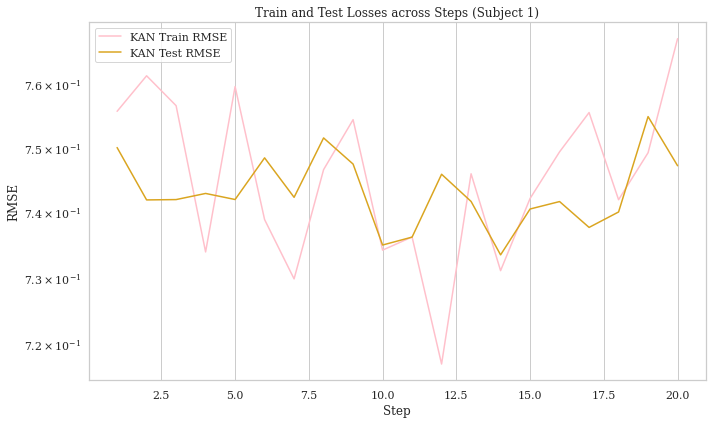

In [72]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=1):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)


In [ ]:
# TWOCLASS_CSP
metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [8]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")
    
    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    df = epochs_EEG.to_data_frame().drop(columns=['time', 'epoch'])
    X = df.drop(columns=['condition']).values
    y = df.condition.values
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)
    
    for param in mlp_model.parameters():
        param.data = param.data.double()
    
    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []
        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []

        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []
        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            # Record training time for KAN
            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            # Save KAN metrics
            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(np.mean(results_kan['train_loss']))
            fold_metrics_KAN_test_loss.append(np.mean(results_kan['test_loss']))

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            # Record training time for MLP
            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            # Save MLP metrics
            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(np.mean(results_mlp['train_loss']))
            fold_metrics_MLP_test_loss.append(np.mean(results_mlp['test_loss']))

        # Store fold results (mean of all epochs for each fold)
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss))

    # Calculate and print the mean of all folds
    mean_train_acc_KAN = np.mean(metrics_KAN[subject]['train_acc'])
    mean_test_acc_KAN = np.mean(metrics_KAN[subject]['test_acc'])
    mean_train_loss_KAN = np.mean(metrics_KAN[subject]['train_loss'])
    mean_test_loss_KAN = np.mean(metrics_KAN[subject]['test_loss'])

    mean_train_acc_MLP = np.mean(metrics_MLP[subject]['train_acc'])
    mean_test_acc_MLP = np.mean(metrics_MLP[subject]['test_acc'])
    mean_train_loss_MLP = np.mean(metrics_MLP[subject]['train_loss'])
    mean_test_loss_MLP = np.mean(metrics_MLP[subject]['test_loss'])

    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {mean_train_acc_KAN}")
    print(f"KAN Mean Testing Accuracy: {mean_test_acc_KAN}")
    print(f"KAN Mean Training Loss: {mean_train_loss_KAN}")
    print(f"KAN Mean Testing Loss: {mean_test_loss_KAN}")

    print(f"MLP Mean Training Accuracy: {mean_train_acc_MLP}")
    print(f"MLP Mean Testing Accuracy: {mean_test_acc_MLP}")
    print(f"MLP Mean Training Loss: {mean_train_loss_MLP}")
    print(f"MLP Mean Testing Loss: {mean_test_loss_MLP}")


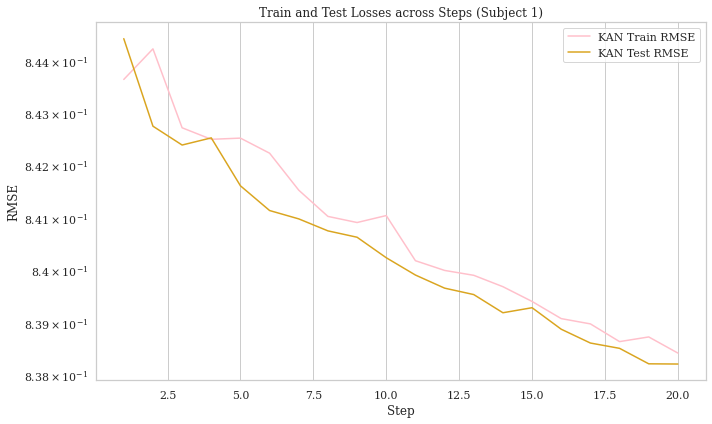

In [28]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=1):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)


In [45]:
# TWOCLASS_raw rmse plot
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))


    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.max(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.max(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


Train Acc: 0.383 | Test Acc: 0.533: 100%|██████████████████████████| 20/20 [00:00<00:00, 516.48it/s]


Reverting to best grid size: 5 with accuracy: 0.633


train acc: 0.817 | test acc: 0.600 : 100%|██████████████████████████| 20/20 [00:00<00:00, 38.25it/s]


###### EPOCH 1 ######


Train Acc: 0.317 | Test Acc: 0.667: 100%|██████████████████████████| 20/20 [00:00<00:00, 536.59it/s]


Reverting to best grid size: 5 with accuracy: 0.683


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 32.64it/s]


###### EPOCH 2 ######


Train Acc: 0.350 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 538.39it/s]


Reverting to best grid size: 5 with accuracy: 0.683


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.12it/s]


###### EPOCH 3 ######


Train Acc: 0.350 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 537.33it/s]


Reverting to best grid size: 5 with accuracy: 0.717


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.65it/s]


###### EPOCH 4 ######


Train Acc: 0.367 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 535.76it/s]


Reverting to best grid size: 5 with accuracy: 0.700


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.66it/s]


###### EPOCH 5 ######


Train Acc: 0.483 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 533.15it/s]


Reverting to best grid size: 5 with accuracy: 0.700


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 68.44it/s]


###### EPOCH 6 ######


Train Acc: 0.533 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 530.74it/s]


Reverting to best grid size: 5 with accuracy: 0.700


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 68.60it/s]


###### EPOCH 7 ######


Train Acc: 0.600 | Test Acc: 0.567: 100%|██████████████████████████| 20/20 [00:00<00:00, 534.01it/s]


Reverting to best grid size: 5 with accuracy: 0.683


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.58it/s]


###### EPOCH 8 ######


Train Acc: 0.683 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 534.96it/s]


Reverting to best grid size: 5 with accuracy: 0.683


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.58it/s]


###### EPOCH 9 ######


Train Acc: 0.733 | Test Acc: 0.600: 100%|██████████████████████████| 20/20 [00:00<00:00, 538.69it/s]


Reverting to best grid size: 5 with accuracy: 0.683


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.45it/s]


###### EPOCH 10 ######


Train Acc: 0.800 | Test Acc: 0.567: 100%|█████████████| 20/20 [00:00<00:00, 528.75it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.717


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 68.81it/s]


###### EPOCH 11 ######


Train Acc: 0.833 | Test Acc: 0.567: 100%|█████████████| 20/20 [00:00<00:00, 523.58it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.750


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 68.79it/s]


###### EPOCH 12 ######


Train Acc: 0.817 | Test Acc: 0.567: 100%|█████████████| 20/20 [00:00<00:00, 521.87it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.750


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.55it/s]


###### EPOCH 13 ######


Train Acc: 0.817 | Test Acc: 0.600: 100%|█████████████| 20/20 [00:00<00:00, 522.49it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.717


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.30it/s]


###### EPOCH 14 ######


Train Acc: 0.867 | Test Acc: 0.567: 100%|██████████████████████████| 20/20 [00:00<00:00, 534.44it/s]


Reverting to best grid size: 5 with accuracy: 0.717


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.51it/s]


###### EPOCH 15 ######


Train Acc: 0.867 | Test Acc: 0.600: 100%|██████████████████████████| 20/20 [00:00<00:00, 534.15it/s]


Reverting to best grid size: 5 with accuracy: 0.717


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.52it/s]


###### EPOCH 16 ######


Train Acc: 0.867 | Test Acc: 0.600: 100%|██████████████████████████| 20/20 [00:00<00:00, 537.18it/s]


Reverting to best grid size: 5 with accuracy: 0.733


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.62it/s]


###### EPOCH 17 ######


Train Acc: 0.850 | Test Acc: 0.617: 100%|██████████████████████████| 20/20 [00:00<00:00, 528.76it/s]


Reverting to best grid size: 5 with accuracy: 0.750


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.56it/s]


###### EPOCH 18 ######


Train Acc: 0.850 | Test Acc: 0.617: 100%|██████████████████████████| 20/20 [00:00<00:00, 540.06it/s]


Reverting to best grid size: 5 with accuracy: 0.750


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.51it/s]


###### EPOCH 19 ######


Train Acc: 0.850 | Test Acc: 0.583: 100%|██████████████████████████| 20/20 [00:00<00:00, 536.18it/s]


Reverting to best grid size: 5 with accuracy: 0.750


train acc: 0.867 | test acc: 0.617 : 100%|██████████████████████████| 20/20 [00:00<00:00, 69.54it/s]


--- Fold 2 ---
###### EPOCH 0 ######


Train Acc: 0.600 | Test Acc: 0.667: 100%|██████████████████████████| 20/20 [00:00<00:00, 515.91it/s]


Reverting to best grid size: 5 with accuracy: 0.850


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 30.17it/s]


###### EPOCH 1 ######


Train Acc: 0.583 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 523.35it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.46it/s]


###### EPOCH 2 ######


Train Acc: 0.567 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 521.93it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.21it/s]


###### EPOCH 3 ######


Train Acc: 0.583 | Test Acc: 0.650: 100%|██████████████████████████| 20/20 [00:00<00:00, 511.69it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.38it/s]


###### EPOCH 4 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 505.45it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.36it/s]


###### EPOCH 5 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 518.38it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.32it/s]


###### EPOCH 6 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 518.55it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.41it/s]


###### EPOCH 7 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 509.65it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.33it/s]


###### EPOCH 8 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 514.46it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.32it/s]


###### EPOCH 9 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 519.22it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.34it/s]


###### EPOCH 10 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 514.07it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.45it/s]


###### EPOCH 11 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 519.39it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.24it/s]


###### EPOCH 12 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 516.65it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.29it/s]


###### EPOCH 13 ######


Train Acc: 0.583 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 508.49it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.35it/s]


###### EPOCH 14 ######


Train Acc: 0.617 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 518.32it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.39it/s]


###### EPOCH 15 ######


Train Acc: 0.617 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 514.67it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.14it/s]


###### EPOCH 16 ######


Train Acc: 0.617 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 518.93it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 76.75it/s]


###### EPOCH 17 ######


Train Acc: 0.633 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 523.47it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.69it/s]


###### EPOCH 18 ######


Train Acc: 0.633 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 512.65it/s]


Reverting to best grid size: 5 with accuracy: 0.817


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.23it/s]


###### EPOCH 19 ######


Train Acc: 0.633 | Test Acc: 0.700: 100%|██████████████████████████| 20/20 [00:00<00:00, 503.85it/s]


Reverting to best grid size: 5 with accuracy: 0.833


train acc: 0.717 | test acc: 0.700 : 100%|██████████████████████████| 20/20 [00:00<00:00, 77.37it/s]

### Subject 1 ###
Training time KAN: 1.63 seconds
Training time MLP: 11.99 seconds
KAN Mean Training Accuracy: 0.7383333325386048
KAN Mean Testing Accuracy: 0.6995833352208138
MLP Mean Training Accuracy: 0.7905416488647461
MLP Mean Testing Accuracy: 0.6579166054725647


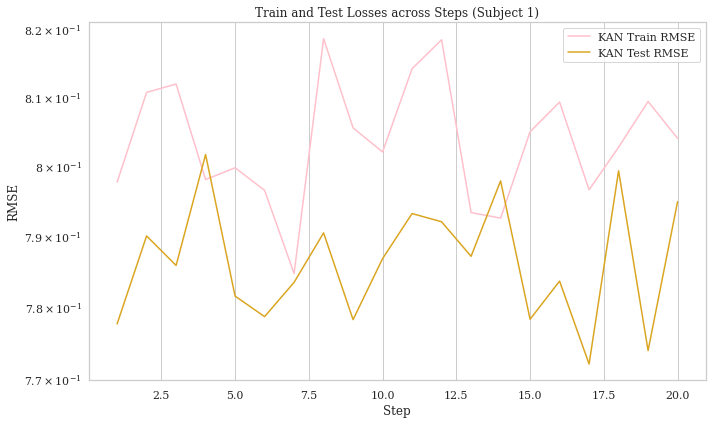

In [46]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=1):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)


In [18]:
# TWOCLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 388.69it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.815


train acc: 0.806 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.79it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 312.62it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.704


train acc: 0.806 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.84it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.639: 100%|█████████████| 50/50 [00:00<00:00, 427.55it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.685


train acc: 0.806 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.30it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.602: 100%|█████████████| 50/50 [00:00<00:00, 425.98it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.676


train acc: 0.806 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.97it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.491: 100%|█████████████| 50/50 [00:00<00:00, 426.02it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.694


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.73it/s]


###### EPOCH 5 ######


train acc: 0.815 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 417.36it/s, grid_size=9]


Reverting to best grid size: 5 with accuracy: 0.704


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.78it/s]


###### EPOCH 6 ######


train acc: 0.815 | test acc: 0.602: 100%|█████████████| 50/50 [00:00<00:00, 425.09it/s, grid_size=9]


Reverting to best grid size: 6 with accuracy: 0.676


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.41it/s]


###### EPOCH 7 ######


train acc: 0.843 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 423.15it/s, grid_size=10]


Reverting to best grid size: 6 with accuracy: 0.648


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.66it/s]


###### EPOCH 8 ######


train acc: 0.843 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 421.59it/s, grid_size=10]


Reverting to best grid size: 9 with accuracy: 0.685


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.88it/s]


###### EPOCH 9 ######


train acc: 0.843 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 421.80it/s, grid_size=13]


Reverting to best grid size: 9 with accuracy: 0.685


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.88it/s]


###### EPOCH 10 ######


train acc: 0.843 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 424.37it/s, grid_size=13]


Reverting to best grid size: 11 with accuracy: 0.648


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.17it/s]


###### EPOCH 11 ######


train acc: 0.843 | test acc: 0.491: 100%|████████████| 50/50 [00:00<00:00, 418.20it/s, grid_size=15]


Reverting to best grid size: 11 with accuracy: 0.676


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.36it/s]


###### EPOCH 12 ######


train acc: 0.843 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 427.69it/s, grid_size=15]


Reverting to best grid size: 13 with accuracy: 0.676


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.50it/s]


###### EPOCH 13 ######


train acc: 0.843 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 422.27it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.722


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.52it/s]


###### EPOCH 14 ######


train acc: 0.843 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 424.93it/s, grid_size=20]


Reverting to best grid size: 16 with accuracy: 0.685


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.28it/s]


###### EPOCH 15 ######


train acc: 0.843 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 423.20it/s, grid_size=20]


Reverting to best grid size: 18 with accuracy: 0.685


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.51it/s]


###### EPOCH 16 ######


train acc: 0.843 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 428.99it/s, grid_size=22]


Reverting to best grid size: 19 with accuracy: 0.676


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.39it/s]


###### EPOCH 17 ######


train acc: 0.843 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 423.84it/s, grid_size=23]


Reverting to best grid size: 21 with accuracy: 0.694


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.49it/s]


###### EPOCH 18 ######


train acc: 0.843 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 424.23it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.685


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.56it/s]


###### EPOCH 19 ######


train acc: 0.843 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 431.68it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.694


train acc: 0.843 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.42it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.843 | test acc: 0.324: 100%|████████████| 50/50 [00:00<00:00, 426.07it/s, grid_size=32]


Reverting to best grid size: 29 with accuracy: 0.546


train acc: 0.815 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.75it/s]


###### EPOCH 1 ######


train acc: 0.815 | test acc: 0.315: 100%|████████████| 50/50 [00:00<00:00, 425.91it/s, grid_size=33]


Reverting to best grid size: 29 with accuracy: 0.602


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.93it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 426.05it/s, grid_size=33]


Reverting to best grid size: 29 with accuracy: 0.565


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.47it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 429.40it/s, grid_size=33]


Reverting to best grid size: 29 with accuracy: 0.500


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.55it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 426.62it/s, grid_size=33]


Reverting to best grid size: 30 with accuracy: 0.602


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.25it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.333: 100%|████████████| 50/50 [00:00<00:00, 391.37it/s, grid_size=34]


Reverting to best grid size: 30 with accuracy: 0.546


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.81it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 419.49it/s, grid_size=34]


Reverting to best grid size: 31 with accuracy: 0.611


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.76it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 365.97it/s, grid_size=35]


Reverting to best grid size: 31 with accuracy: 0.583


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.80it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 0.361: 100%|████████████| 50/50 [00:00<00:00, 415.49it/s, grid_size=35]


Reverting to best grid size: 31 with accuracy: 0.565


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.83it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 403.80it/s, grid_size=35]


Reverting to best grid size: 32 with accuracy: 0.574


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.64it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 0.278: 100%|████████████| 50/50 [00:00<00:00, 423.70it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.602


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.04it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 0.315: 100%|████████████| 50/50 [00:00<00:00, 426.60it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.620


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.98it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 0.389: 100%|████████████| 50/50 [00:00<00:00, 426.16it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.574


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.16it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 424.63it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.602


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.06it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 0.333: 100%|████████████| 50/50 [00:00<00:00, 376.71it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.565


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.03it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 381.52it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.583


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.92it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 0.296: 100%|████████████| 50/50 [00:00<00:00, 426.56it/s, grid_size=36]


Reverting to best grid size: 34 with accuracy: 0.537


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.50it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 0.296: 100%|████████████| 50/50 [00:00<00:00, 424.27it/s, grid_size=38]


Reverting to best grid size: 34 with accuracy: 0.565


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.25it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 429.39it/s, grid_size=38]


Reverting to best grid size: 35 with accuracy: 0.630


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.31it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 0.278: 100%|████████████| 50/50 [00:00<00:00, 426.23it/s, grid_size=39]


Reverting to best grid size: 35 with accuracy: 0.546


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.35it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 428.53it/s, grid_size=39]


Reverting to best grid size: 35 with accuracy: 0.880


train acc: 0.796 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.14it/s]


###### EPOCH 1 ######


train acc: 0.796 | test acc: 0.759: 100%|████████████| 50/50 [00:00<00:00, 426.23it/s, grid_size=39]


Reverting to best grid size: 35 with accuracy: 0.963


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.76it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 0.722: 100%|████████████| 50/50 [00:00<00:00, 429.22it/s, grid_size=39]


Reverting to best grid size: 36 with accuracy: 0.870


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.10it/s]


###### EPOCH 3 ######


train acc: 0.787 | test acc: 0.750: 100%|████████████| 50/50 [00:00<00:00, 417.18it/s, grid_size=40]


Reverting to best grid size: 38 with accuracy: 0.889


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.56it/s]


###### EPOCH 4 ######


train acc: 0.787 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 365.54it/s, grid_size=42]


Reverting to best grid size: 38 with accuracy: 0.880


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.08it/s]


###### EPOCH 5 ######


train acc: 0.787 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 364.47it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.898


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.92it/s]


###### EPOCH 6 ######


train acc: 0.787 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 366.09it/s, grid_size=44]


Reverting to best grid size: 40 with accuracy: 0.898


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.86it/s]


###### EPOCH 7 ######


train acc: 0.787 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 379.72it/s, grid_size=44]


Reverting to best grid size: 40 with accuracy: 0.880


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.92it/s]


###### EPOCH 8 ######


train acc: 0.787 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 405.79it/s, grid_size=44]


Reverting to best grid size: 40 with accuracy: 0.926


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.94it/s]


###### EPOCH 9 ######


train acc: 0.787 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 404.29it/s, grid_size=44]


Reverting to best grid size: 41 with accuracy: 0.917


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.85it/s]


###### EPOCH 10 ######


train acc: 0.787 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 427.24it/s, grid_size=45]


Reverting to best grid size: 41 with accuracy: 0.926


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.30it/s]


###### EPOCH 11 ######


train acc: 0.787 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 409.27it/s, grid_size=45]


Reverting to best grid size: 41 with accuracy: 0.889


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.82it/s]


###### EPOCH 12 ######


train acc: 0.787 | test acc: 0.759: 100%|████████████| 50/50 [00:00<00:00, 422.98it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.907


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.89it/s]


###### EPOCH 13 ######


train acc: 0.787 | test acc: 0.722: 100%|████████████| 50/50 [00:00<00:00, 426.90it/s, grid_size=47]


Reverting to best grid size: 44 with accuracy: 0.870


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.90it/s]


###### EPOCH 14 ######


train acc: 0.787 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 423.22it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.907


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.87it/s]


###### EPOCH 15 ######


train acc: 0.787 | test acc: 0.787: 100%|████████████| 50/50 [00:00<00:00, 433.25it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.93it/s]


###### EPOCH 16 ######


train acc: 0.787 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.99it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.25it/s]


###### EPOCH 17 ######


train acc: 0.787 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 449.79it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.88it/s]


###### EPOCH 18 ######


train acc: 0.787 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.01it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.43it/s]


###### EPOCH 19 ######


train acc: 0.787 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.91it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.787 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.75it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.787 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 428.95it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.05it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 0.880: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.11it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.78it/s]


###### EPOCH 2 ######


train acc: 0.769 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.62it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.00it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.84it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.14it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.870: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.22it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.94it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.28it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.27it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.22it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.70it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 432.28it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.28it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.74it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.38it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.61it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.34it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.852: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.84it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.84it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.907: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.27it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.68it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 431.74it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.01it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 419.61it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.07it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.03it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.95it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.91it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.96it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.833: 100%|██████████████████████████| 50/50 [00:00<00:00, 422.42it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.05it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.81it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.52it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.86it/s]


Reverting to best grid size: 50 with accuracy: 0.926


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.27it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 418.06it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.53it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 431.89it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.41it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 432.20it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.43it/s]


###### EPOCH 2 ######


train acc: 0.806 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.72it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.62it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 381.34it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.76it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 364.55it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.72it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 429.14it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.78it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.11it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.73it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 427.13it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.61it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 447.04it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.17it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.57it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.96it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 321.12it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.11it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.15it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.40it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.75it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.80it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 320.20it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.56it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 429.38it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.83it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 450.36it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.67it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 458.00it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.45it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 449.40it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.42it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 448.43it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.52it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 448.99it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.806 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.15it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.00it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.32it/s]


###### EPOCH 1 ######


train acc: 0.778 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.83it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.91it/s]


###### EPOCH 2 ######


train acc: 0.778 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.05it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.34it/s]


###### EPOCH 3 ######


train acc: 0.778 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.35it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.24it/s]


###### EPOCH 4 ######


train acc: 0.778 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.48it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.22it/s]


###### EPOCH 5 ######


train acc: 0.778 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.18it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.25it/s]


###### EPOCH 6 ######


train acc: 0.778 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 440.17it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.44it/s]


###### EPOCH 7 ######


train acc: 0.778 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.93it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.35it/s]


###### EPOCH 8 ######


train acc: 0.778 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.46it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.31it/s]


###### EPOCH 9 ######


train acc: 0.778 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.67it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.35it/s]


###### EPOCH 10 ######


train acc: 0.778 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.31it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.42it/s]


###### EPOCH 11 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 440.22it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.45it/s]


###### EPOCH 12 ######


train acc: 0.778 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.41it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.30it/s]


###### EPOCH 13 ######


train acc: 0.778 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 444.64it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.60it/s]


###### EPOCH 14 ######


train acc: 0.778 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.71it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.35it/s]


###### EPOCH 15 ######


train acc: 0.778 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.15it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.58it/s]


###### EPOCH 16 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 431.71it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.30it/s]


###### EPOCH 17 ######


train acc: 0.778 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.32it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.55it/s]


###### EPOCH 18 ######


train acc: 0.778 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.06it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.39it/s]


###### EPOCH 19 ######


train acc: 0.778 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.35it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.778 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.61it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.778 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.29it/s]


Reverting to best grid size: 50 with accuracy: 0.852


train acc: 0.759 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.29it/s]


###### EPOCH 1 ######


train acc: 0.759 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.64it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.759 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.76it/s]


###### EPOCH 2 ######


train acc: 0.759 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.67it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.38it/s]


###### EPOCH 3 ######


train acc: 0.769 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.50it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.43it/s]


###### EPOCH 4 ######


train acc: 0.769 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 443.29it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.51it/s]


###### EPOCH 5 ######


train acc: 0.769 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.70it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.42it/s]


###### EPOCH 6 ######


train acc: 0.769 | test acc: 0.815: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.50it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.65it/s]


###### EPOCH 7 ######


train acc: 0.769 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.61it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.60it/s]


###### EPOCH 8 ######


train acc: 0.769 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.04it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.48it/s]


###### EPOCH 9 ######


train acc: 0.769 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.91it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.59it/s]


###### EPOCH 10 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.26it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.50it/s]


###### EPOCH 11 ######


train acc: 0.769 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.75it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.32it/s]


###### EPOCH 12 ######


train acc: 0.769 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.15it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.44it/s]


###### EPOCH 13 ######


train acc: 0.769 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 443.76it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.49it/s]


###### EPOCH 14 ######


train acc: 0.769 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.31it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.50it/s]


###### EPOCH 15 ######


train acc: 0.769 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.22it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.70it/s]


###### EPOCH 16 ######


train acc: 0.769 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.23it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.60it/s]


###### EPOCH 17 ######


train acc: 0.769 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.17it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.57it/s]


###### EPOCH 18 ######


train acc: 0.769 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.09it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.48it/s]


###### EPOCH 19 ######


train acc: 0.769 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.44it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.62it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.769 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.45it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.769 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.70it/s]


###### EPOCH 1 ######


train acc: 0.769 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.02it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.787 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.33it/s]


###### EPOCH 2 ######


train acc: 0.787 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.62it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.14it/s]


###### EPOCH 3 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.30it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 83.35it/s]


###### EPOCH 4 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.79it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.15it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.17it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.61it/s]


###### EPOCH 6 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.79it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.52it/s]


###### EPOCH 7 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.43it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.36it/s]


###### EPOCH 8 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.01it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.72it/s]


###### EPOCH 9 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.98it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.38it/s]


###### EPOCH 10 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.13it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.25it/s]


###### EPOCH 11 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.88it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.19it/s]


###### EPOCH 12 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.02it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.75it/s]


###### EPOCH 13 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.68it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.61it/s]


###### EPOCH 14 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 458.93it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.28it/s]


###### EPOCH 15 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 445.65it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.50it/s]


###### EPOCH 16 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 449.32it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.77it/s]


###### EPOCH 17 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 447.99it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.24it/s]


###### EPOCH 18 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 443.72it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.74it/s]


###### EPOCH 19 ######


train acc: 0.806 | test acc: 1.000: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.96it/s]


Reverting to best grid size: 50 with accuracy: 1.000


train acc: 0.806 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.46it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.806 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.26it/s]


Reverting to best grid size: 50 with accuracy: 0.954


train acc: 0.806 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.69it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 430.98it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.19it/s]


###### EPOCH 2 ######


train acc: 0.815 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 431.68it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.66it/s]


###### EPOCH 3 ######


train acc: 0.815 | test acc: 0.787: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.88it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.62it/s]


###### EPOCH 4 ######


train acc: 0.815 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 430.18it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.55it/s]


###### EPOCH 5 ######


train acc: 0.815 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 448.69it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.30it/s]


###### EPOCH 6 ######


train acc: 0.815 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.65it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.47it/s]


###### EPOCH 7 ######


train acc: 0.815 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.13it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.04it/s]


###### EPOCH 8 ######


train acc: 0.815 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 343.55it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.67it/s]


###### EPOCH 9 ######


train acc: 0.815 | test acc: 0.806: 100%|██████████████████████████| 50/50 [00:00<00:00, 337.62it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.36it/s]


###### EPOCH 10 ######


train acc: 0.815 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 444.94it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.71it/s]


###### EPOCH 11 ######


train acc: 0.815 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 444.16it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.46it/s]


###### EPOCH 12 ######


train acc: 0.815 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.86it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.81it/s]


###### EPOCH 13 ######


train acc: 0.815 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.24it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.65it/s]


###### EPOCH 14 ######


train acc: 0.815 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.53it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.68it/s]


###### EPOCH 15 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 442.69it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.21it/s]


###### EPOCH 16 ######


train acc: 0.815 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.47it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.62it/s]


###### EPOCH 17 ######


train acc: 0.815 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 441.66it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.80it/s]


###### EPOCH 18 ######


train acc: 0.815 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.97it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.53it/s]


###### EPOCH 19 ######


train acc: 0.815 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 428.47it/s]


Reverting to best grid size: 50 with accuracy: 0.898


train acc: 0.815 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.65it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.815 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 439.55it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.806 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.79it/s]


###### EPOCH 1 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.57it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.91it/s]


###### EPOCH 2 ######


train acc: 0.796 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.49it/s]


Reverting to best grid size: 50 with accuracy: 0.889


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.44it/s]


###### EPOCH 3 ######


train acc: 0.796 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.35it/s]


Reverting to best grid size: 50 with accuracy: 0.963


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.27it/s]


###### EPOCH 4 ######


train acc: 0.796 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.73it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.806 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.66it/s]


###### EPOCH 5 ######


train acc: 0.806 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.93it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.93it/s]


###### EPOCH 6 ######


train acc: 0.833 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 428.83it/s]


Reverting to best grid size: 50 with accuracy: 0.944


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.26it/s]


###### EPOCH 7 ######


train acc: 0.833 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.31it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.86it/s]


###### EPOCH 8 ######


train acc: 0.833 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.54it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.72it/s]


###### EPOCH 9 ######


train acc: 0.833 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.88it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.74it/s]


###### EPOCH 10 ######


train acc: 0.833 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 435.61it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.72it/s]


###### EPOCH 11 ######


train acc: 0.833 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 436.17it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.91it/s]


###### EPOCH 12 ######


train acc: 0.833 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 434.41it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.76it/s]


###### EPOCH 13 ######


train acc: 0.833 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 443.32it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.73it/s]


###### EPOCH 14 ######


train acc: 0.833 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 433.68it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.86it/s]


###### EPOCH 15 ######


train acc: 0.833 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 438.36it/s]


Reverting to best grid size: 50 with accuracy: 0.917


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.02it/s]


###### EPOCH 16 ######


train acc: 0.833 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 437.80it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.04it/s]


###### EPOCH 17 ######


train acc: 0.833 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 452.18it/s]


Reverting to best grid size: 50 with accuracy: 0.907


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.12it/s]


###### EPOCH 18 ######


train acc: 0.833 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 444.17it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.06it/s]


###### EPOCH 19 ######


train acc: 0.833 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 453.30it/s]


Reverting to best grid size: 50 with accuracy: 0.935


train acc: 0.833 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.89it/s]

### Subject 1 ###
Training time KAN: 24.12 seconds
Training time MLP: 170.00 seconds
KAN Mean Training Accuracy: 0.798611044883728
KAN Mean Testing Accuracy: 0.6805880069732666
MLP Mean Training Accuracy: 0.7985666394233704
MLP Mean Testing Accuracy: 0.6783249974250793


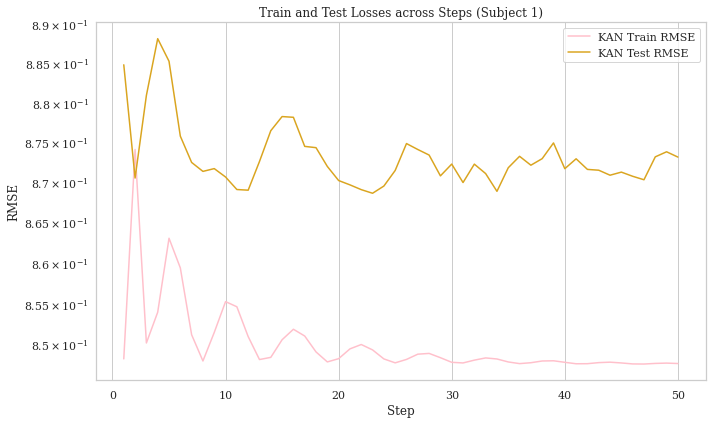

In [19]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=2):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)
